In [2]:
import os
import sys
from collections import defaultdict, Counter
from functools import reduce, partial
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from scipy.stats import bootstrap, binom_test
from statsmodels.stats.multitest import multipletests
from ete3 import PhyloTree
from Bio import SeqIO

from pymutspec.draw import plot_mutspec12, plot_mutspec192
from pymutspec.annotation import rev_comp, CodonAnnotation, transcriptor, mutations_summary
from pymutspec.constants import possible_sbs192, possible_sbs12

from utils import calc_phylocoefs

#### merge cytb of spretus and musculus

In [18]:
def read_mapping(fn) -> dict:
    with open(fn) as fin:
        lines = [x.strip() for x in fin.readlines()]
        assert len(lines) % 2 == 0
        mapping = dict(zip(lines[::2], lines[1::2]))
    return mapping


musculus_seqs = [x for x in SeqIO.parse("../data/selection_search/mouse_cytb/sequences/seqs_unique.fasta", "fasta")]
spretus_seqs =  [x for x in SeqIO.parse("../data/selection_search/spretus_cytb/sequences/seqs_unique.fasta", "fasta")]

musculus_mapping = read_mapping("../data/selection_search/mouse_cytb/sequences/headers_mapping.txt")
spretus_mapping  = read_mapping("../data/selection_search/spretus_cytb/sequences/headers_mapping.txt")

In [19]:
for rec in musculus_seqs:
    rec.id = ""
    rec.description = musculus_mapping[rec.description]

for rec in spretus_seqs:
    rec.id = ""
    rec.description = spretus_mapping[rec.description]

In [20]:
SeqIO.write(spretus_seqs, "../bla.fasta", "fasta-2line")

183

## Load data species-gene specific

In [3]:
mouse_cytb = dict()
mouse_cox1 = dict()
mouse_nd1 = dict()
human_cytb = dict()
human_cox1 = dict()
human_nd1 = dict()


def get_consensus(aln):
    seq = []
    for column in zip(*aln):
        nuc = Counter(column).most_common()[0][0]
        seq.append(nuc)
    return "".join(seq)


for dct, gene in zip(
        [mouse_cytb, mouse_cox1, mouse_nd1, human_cytb, human_cox1, human_nd1], 
        ["mouse_cytb", "mouse_cox1", "mouse_nd1", "human_cytb", "human_cox1", "human_nd1"]
    ):
    indir = f"../data/selection_search/{gene}/"

    dct["aln"] = [str(x.seq) for x in SeqIO.parse(indir + "sequences/alignment_checked.fasta", format="fasta")]
    dct["mutations"] = pd.read_csv(indir + "tables/observed_mutations_iqtree.tsv", sep="\t").sort_values("PosInGene")
    dct["exp_muts"]  = pd.read_csv(indir + "exp_muts_invariant.tsv", sep="\t").set_index("Mut").Count.to_dict()
    dct["rate"] = pd.read_csv(f"../data/selection_search/rates/{gene}.rate", sep="\t", comment="#")
    dct["rate"]["Site"] = np.arange(dct["rate"].shape[0]) + 1
    dct["var_pos"] = dct["rate"][dct["rate"]["Cat"] > 0]["Site"].values
    dct["consensus"] = get_consensus(dct["aln"])

    assert len(dct["rate"]) == len(dct["consensus"])

    dct["ms_rec192"] = pd.read_csv(indir + f"ms/ms192syn_internal_{gene}.tsv", sep="\t")
    dct["ms_rec12"]  = pd.read_csv(indir + f"ms/ms12syn_internal_{gene}.tsv", sep="\t")
    dct["ms_sim192"] = pd.read_csv(indir + f"pyvolve/out/ms192syn_{gene}_simulated.tsv", sep="\t")
    dct["ms_sim12"]  = pd.read_csv(indir + f"pyvolve/out/ms12syn_{gene}_simulated.tsv", sep="\t")

    dct["ms_sim192_internal"] = pd.read_csv(indir + f"pyvolve/out/ms192syn_{gene}_internal_simulated.tsv", sep="\t")
    dct["ms_sim12_internal"]  = pd.read_csv(indir + f"pyvolve/out/ms12syn_{gene}_internal_simulated.tsv", sep="\t")

    dct["tree"] = PhyloTree(os.path.join(indir, "IQTREE/iqtree_anc_tree.nwk"), format=1)

## Little EDA

In [7]:
human_cytb["consensus"]

'ATGACCCCAATACGCAAAATTAACCCCCTAATAAAATTAATTAACCACTCATTCATCGACCTCCCCACCCCATCCAACATCTCCGCATGATGAAACTTCGGCTCACTCCTTGGCGCCTGCCTGATCCTCCAAATCACCACAGGACTATTCCTAGCCATGCACTACTCACCAGACGCCTCAACCGCCTTTTCATCAATCGCCCACATCACTCGAGACGTAAATTATGGCTGAATCATCCGCTACCTTCACGCCAATGGCGCCTCAATATTCTTTATCTGCCTCTTCCTACACATCGGGCGAGGCCTATATTACGGATCATTTCTCTACTCAGAAACCTGAAACATCGGCATTATCCTCCTGCTTGCAACTATAGCAACAGCCTTCATAGGCTATGTCCTCCCGTGAGGCCAAATATCATTCTGAGGGGCCACAGTAATTACAAACTTACTATCCGCCATCCCATACATTGGGACAGACCTAGTTCAATGAATCTGAGGAGGCTACTCAGTAGACAGTCCCACCCTCACACGATTCTTTACCTTTCACTTCATCTTGCCCTTCATTATTGCAGCCCTAGCAGCACTCCACCTCCTATTCTTGCACGAAACGGGATCAAACAACCCCCTAGGAATCACCTCCCATTCCGATAAAATCACCTTCCACCCTTACTACACAATCAAAGACGCCCTCGGCTTACTTCTCTTCCTTCTCTCCTTAATGACATTAACACTATTCTCACCAGACCTCCTAGGCGACCCAGACAATTATACCCTAGCCAACCCCTTAAACACCCCTCCCCACATCAAGCCCGAATGATATTTCCTATTCGCCTACACAATTCTCCGATCCGTCCCTAACAAACTAGGAGGCGTCCTTGCCCTATTACTATCCATCCTCATCCTAGCAATAATCCCCATCCTCCATATATCCAAACAACAAAGCATAATATTTCGCCCACTAAGCCAATCACTTTATTGACTCCTAGCCGCAGACCTCCTC

### Plot rec spectra

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


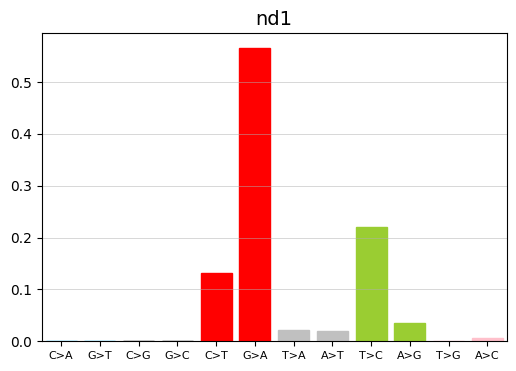

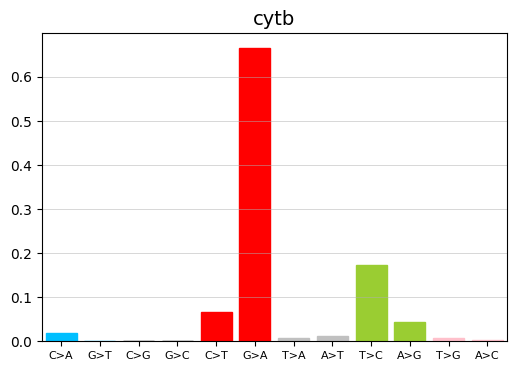

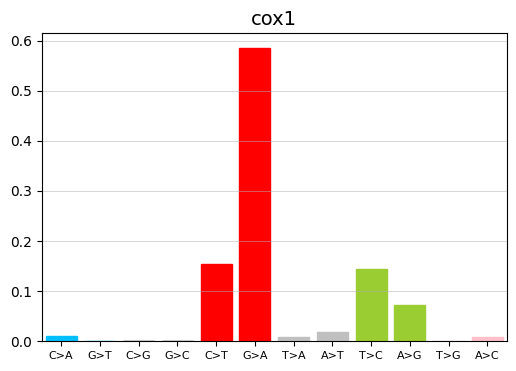

<AxesSubplot:title={'center':'cox1'}>

In [8]:
plot_mutspec12(mouse_nd1['ms_rec12'], title="nd1")
plot_mutspec12(mouse_cytb['ms_rec12'], title="cytb")
plot_mutspec12(mouse_cox1['ms_rec12'], title="cox1")

### Table with observed mutations numbers depending on RateCat

In [9]:
x = pd.concat([
    mouse_cox1["mutations"].merge(mouse_cox1["rate"], left_on="PosInGene", right_on="Site").assign(Gene="mouse_cox1"),
    mouse_cytb["mutations"].merge(mouse_cytb["rate"], left_on="PosInGene", right_on="Site").assign(Gene="mouse_cytb"),
    mouse_nd1["mutations"].merge(mouse_nd1["rate"], left_on="PosInGene", right_on="Site").assign(Gene="mouse_nd1"),
    human_cox1["mutations"].merge(human_cox1["rate"], left_on="PosInGene", right_on="Site").assign(Gene="human_cox1"),
    human_cytb["mutations"].merge(human_cytb["rate"], left_on="PosInGene", right_on="Site").assign(Gene="human_cytb"),
    human_nd1["mutations"].merge(human_nd1["rate"], left_on="PosInGene", right_on="Site").assign(Gene="human_nd1"),
], ignore_index=True).groupby(["Gene", "Cat", "Label"]).ProbaFull.sum().astype(np.float64).unstack().fillna(0.).round(2)

x.columns = x.columns.map({0: "non-syn", 1: "syn", 2: "syn4f"})
x["syn"] = x["syn"] + x["syn4f"]
x = x.reset_index().rename(columns={"Cat":"RateCat"})
x.to_csv("../data/share/nmuts_human_mouse.csv", index=False, float_format="%.2f")
x

Label,Gene,RateCat,non-syn,syn,syn4f
0,human_cox1,0,267.25,172.50,79.05
1,human_cox1,2,106.71,34.93,20.96
2,human_cox1,3,124.11,367.69,230.90
3,human_cox1,4,54.87,207.57,92.80
4,human_cox1,5,149.05,593.16,311.57
5,human_cox1,6,244.55,1658.15,992.86
6,human_cytb,0,243.04,207.48,98.20
7,human_cytb,1,39.14,0.00,0.00
8,human_cytb,2,161.86,6.76,2.88
9,human_cytb,3,227.51,349.62,184.98


In [10]:
x = pd.concat([
    mouse_cox1["mutations"].merge(mouse_cox1["rate"], left_on="PosInGene", right_on="Site").assign(Gene="mouse_cox1"),
    mouse_cytb["mutations"].merge(mouse_cytb["rate"], left_on="PosInGene", right_on="Site").assign(Gene="mouse_cytb"),
    mouse_nd1["mutations"].merge(mouse_nd1["rate"], left_on="PosInGene", right_on="Site").assign(Gene="mouse_nd1"),
    human_cox1["mutations"].merge(human_cox1["rate"], left_on="PosInGene", right_on="Site").assign(Gene="human_cox1"),
    human_cytb["mutations"].merge(human_cytb["rate"], left_on="PosInGene", right_on="Site").assign(Gene="human_cytb"),
    human_nd1["mutations"].merge(human_nd1["rate"], left_on="PosInGene", right_on="Site").assign(Gene="human_nd1"),
], ignore_index=True)
x = x[x.ProbaFull > 0.3].groupby(["Gene", "Cat", "Label"]).ProbaFull.sum().astype(np.float64).unstack().fillna(0.).round(2)

x.columns = x.columns.map({0: "non-syn", 1: "syn", 2: "syn4f"})
x["syn"] = x["syn"] + x["syn4f"]
x = x.reset_index().rename(columns={"Cat":"RateCat"})
x.to_csv("../data/share/nmuts_human_mouse_filter_proba_03.csv", index=False, float_format="%.2f")

## Position Invariativity QC

### Obs mutations

In [78]:
to_concat = []
for lbl, data in zip(
        ['human_cytb', 'human_cox1', 'human_nd1', 'mouse_cytb', 'mouse_cox1', 'mouse_nd1'], 
        [human_cytb, human_cox1, human_nd1, mouse_cytb, mouse_cox1, mouse_nd1]
    ):
    df = data["mutations"].merge(data['rate'], right_on="Site", left_on="PosInGene")
    df['IsTerminal'] = df.AltNode.str.startswith("RN_")
    df["Gene"] = lbl
    to_concat.append(df)
df = pd.concat(to_concat, ignore_index=True)

In [79]:
x = df[(df.ProbaFull > 0.3)].groupby(["Cat", "Gene", "Label", "AltNode", "IsTerminal"]).ProbaFull.sum().reset_index()
x

,Cat,Gene,Label,AltNode,IsTerminal,ProbaFull
0,0,human_cox1,0,Node1064,False,0.999992
1,0,human_cox1,0,Node1094,False,0.999993
2,0,human_cox1,0,Node1216,False,0.997562
3,0,human_cox1,0,Node1228,False,0.995133
4,0,human_cox1,0,Node1258,False,0.996160
...,...,...,...,...,...,...
12182,6,mouse_nd1,2,RN_67,True,0.999997
12183,6,mouse_nd1,2,RN_72,True,0.998016
12184,6,mouse_nd1,2,RN_81,True,0.999989
12185,6,mouse_nd1,2,RN_83,True,0.988434


In [80]:
x[x.Cat == 0]#.groupby("Gene").ProbaFull.sum()

,Cat,Gene,Label,AltNode,IsTerminal,ProbaFull
0,0,human_cox1,0,Node1064,False,0.999992
1,0,human_cox1,0,Node1094,False,0.999993
2,0,human_cox1,0,Node1216,False,0.997562
3,0,human_cox1,0,Node1228,False,0.995133
4,0,human_cox1,0,Node1258,False,0.996160
...,...,...,...,...,...,...
1109,0,mouse_cytb,2,Node93,False,0.989340
1110,0,mouse_cytb,2,RN_346,True,0.996471
1111,0,mouse_cytb,2,RN_369,True,0.999994
1112,0,mouse_cytb,2,RN_378,True,0.996422


In [81]:
# df[(df.Gene.str.startswith("human"))].to_csv("../data/human_mutations.csv", index=False)
# df[(df.Gene.str.startswith("mus"))].to_csv("../data/mouse_mutations.csv", index=False)

In [82]:
df[(df.Gene == "human_cytb") & (df.Cat == 0) & (df.AltNode.str.startswith("Node"))]

,Mut,Label,PosInGene,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,ProbaRef,ProbaMut,...,Gene,RefPhylocoef,RefPhylocoefTrue,AltPhylocoefTrue,ProbaNotFull,Site,Rate,Cat,C_Rate,IsTerminal
58,A[A>G]A,1,18,3,AAA,AAG,K,K,1.00000,1.000000,...,human_cytb,0.942053,0.942053,0.999943,0.942053,18,0.22257,0,0.0,False
342,A[C>T]T,1,48,3,CAC,CAT,H,H,1.00000,1.000000,...,human_cytb,0.943464,0.943464,0.999817,0.943464,48,0.23474,0,0.0,False
454,A[C>T]C,1,60,3,GAC,GAT,D,D,1.00000,1.000000,...,human_cytb,0.942701,0.942701,0.999936,0.942701,60,0.23474,0,0.0,False
606,G[A>G]T,0,124,1,ATC,GTC,I,V,1.00000,1.000000,...,human_cytb,0.942745,0.942745,0.999949,0.942745,124,0.22257,0,0.0,False
611,G[A>G]T,0,124,1,ATC,GTC,I,V,1.00000,1.000000,...,human_cytb,0.941243,0.941243,0.999882,0.941243,124,0.22257,0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4512,A[T>C]G,0,1135,1,TGG,CGG,W,R,0.74377,0.191008,...,human_cytb,0.962561,0.962561,0.962594,0.183856,1135,0.13319,0,0.0,False
4513,A[C>T]G,0,1135,1,CGG,TGG,R,W,0.25623,0.190428,...,human_cytb,0.962561,0.962561,0.962594,0.183298,1135,0.13319,0,0.0,False
4514,A[T>C]G,0,1135,1,TGG,CGG,W,R,0.09530,0.086290,...,human_cytb,0.999890,0.999890,0.999934,0.086281,1135,0.13319,0,0.0,False
4516,A[C>T]G,0,1135,1,CGG,TGG,R,W,0.90470,0.085530,...,human_cytb,0.999890,0.999890,0.999934,0.085521,1135,0.13319,0,0.0,False


In [83]:
print(",".join(df[(df.Gene == "human_cytb") & (df.Cat == 0) & (df.AltNode.str.startswith("Node"))].AltNode.unique()))

Node620,Node2618,Node1861,Node1834,Node3567,Node2341,Node2059,Node4629,Node1009,Node4244,Node4126,Node744,Node2235,Node3560,Node1342,Node1808,Node3857,Node1915,Node1398,Node2911,Node1642,Node1644,Node3747,Node3305,Node1408,Node1832,Node3802,Node226,Node1652,Node4142,Node318,Node1523,Node1541,Node4539,Node621,Node1441,Node2882,Node4477,Node4889,Node2358,Node4190,Node1011,Node4568,Node1722,Node4430,Node3754,Node4866,Node4511,Node2932,Node3450,Node4892,Node4178,Node1625,Node3134,Node4901,Node1376,Node1465,Node3647,Node4186,Node1643,Node608,Node3881,Node1274,Node2454,Node3778,Node4396,Node3555,Node1460,Node986,Node3506,Node1484,Node1979,Node3207,Node1918,Node3336,Node3335,Node957,Node2288,Node3565,Node895,Node3353,Node1414,Node1412,Node1413,Node1415,Node1411


In [84]:
print(",".join(df[(df.Gene == "human_nd1") & (df.Cat == 0) & (df.AltNode.str.startswith("Node"))].AltNode.unique()))

Node2743,Node1100,Node2259,Node1935,Node882,Node1266,Node1606,Node2536,Node74,Node1631,Node2291,Node105,Node2716,Node2728,Node1667,Node473,Node2047,Node226,Node3181,Node3179,Node95,Node531,Node1730,Node1052,Node2431,Node625,Node2090,Node1587,Node2106,Node2319,Node2708,Node1906,Node1691,Node717,Node2008,Node2020,Node2304,Node276,Node256,Node3163,Node2297,Node1096,Node1302,Node199,Node3075,Node1584,Node3213,Node2884,Node1704,Node781,Node388,Node1990,Node1383,Node324,Node2709,Node201,Node206,Node1907,Node1903,Node2667


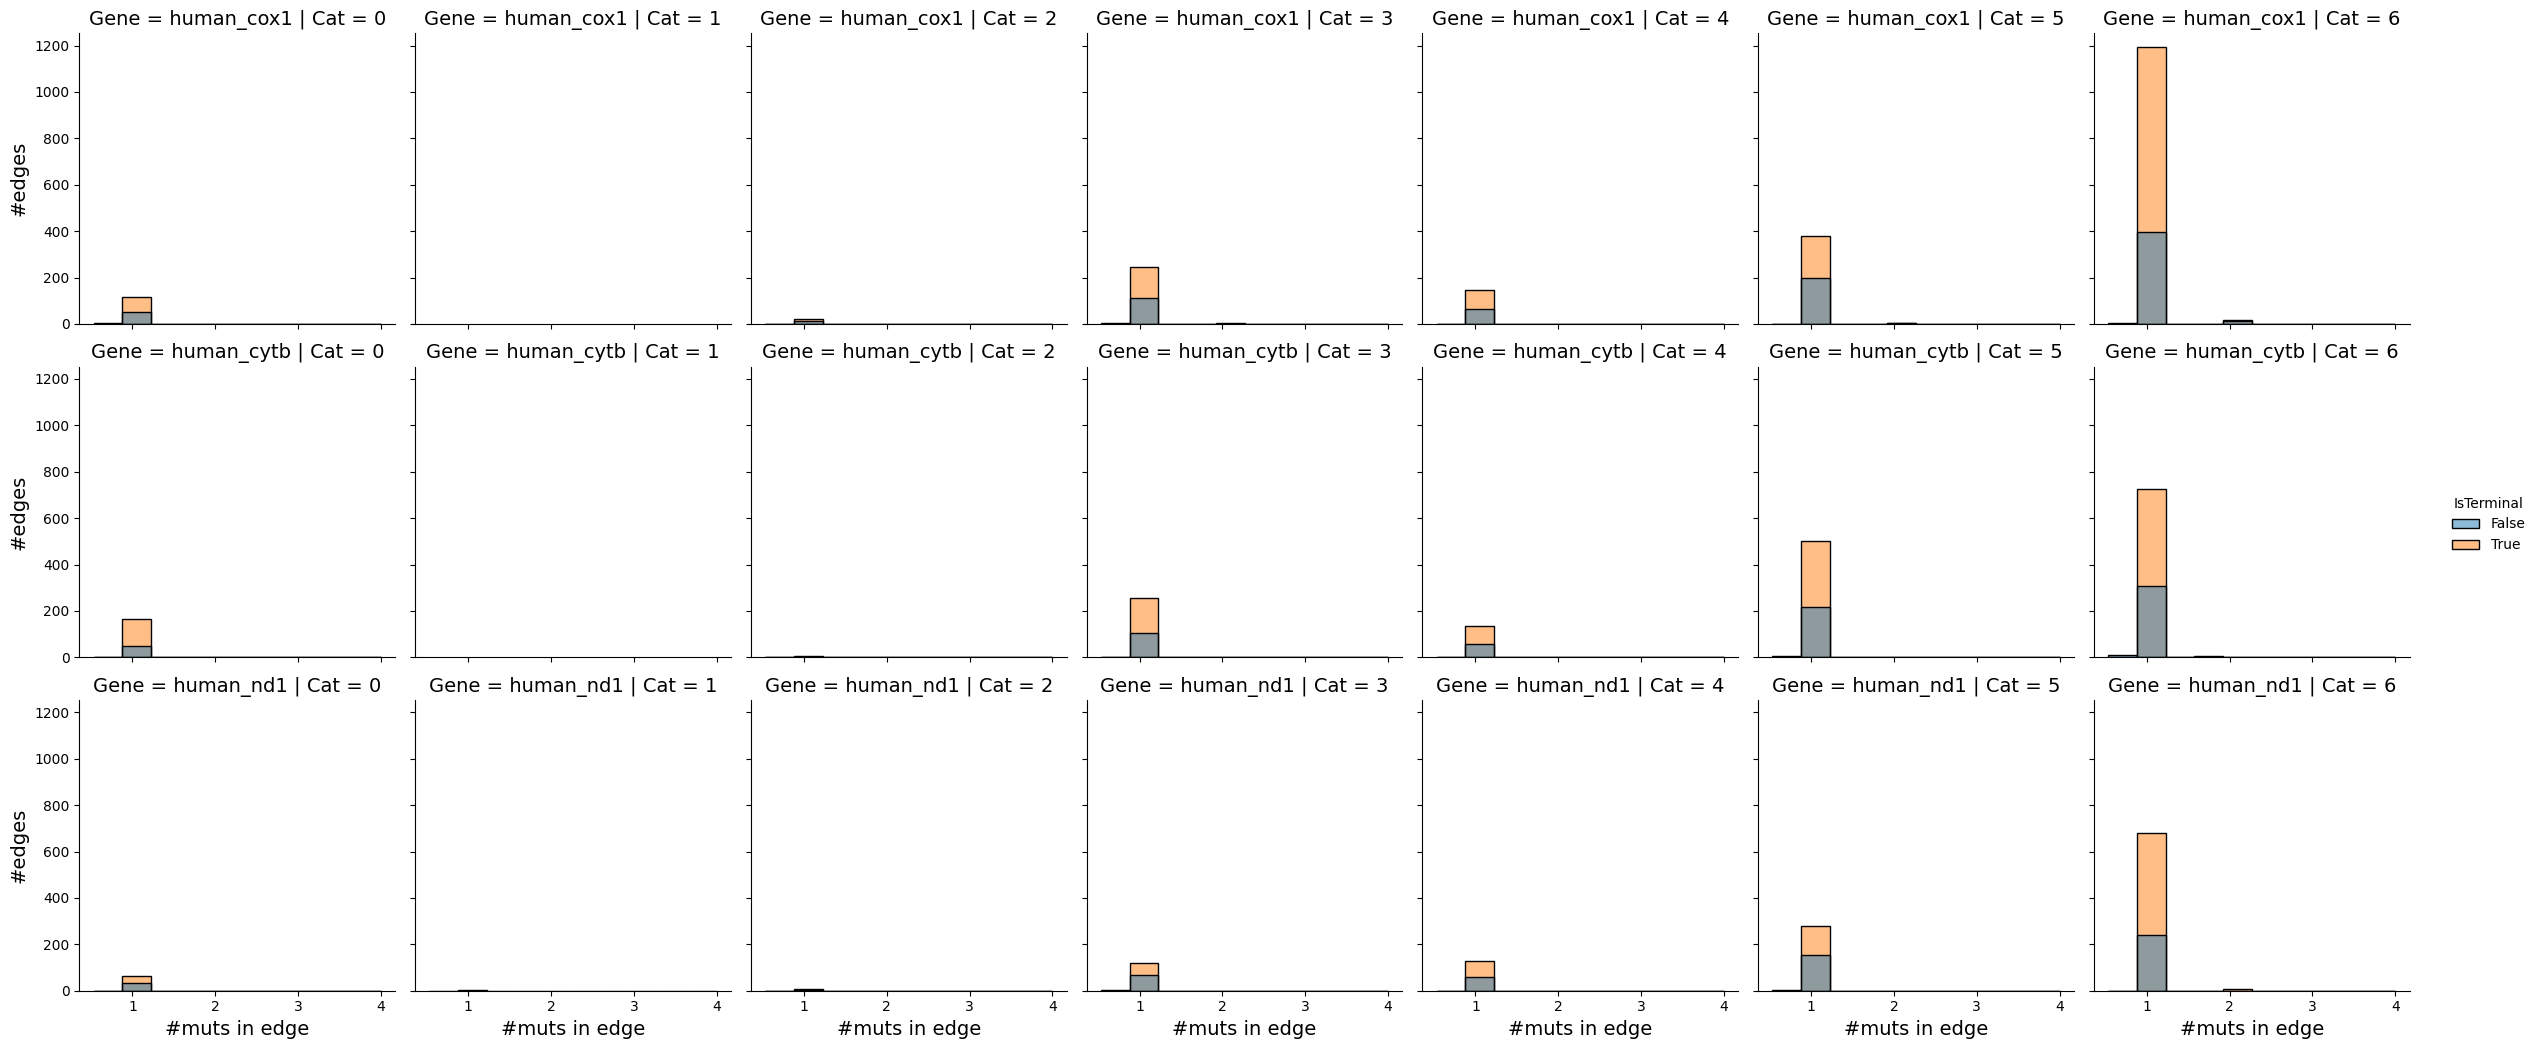

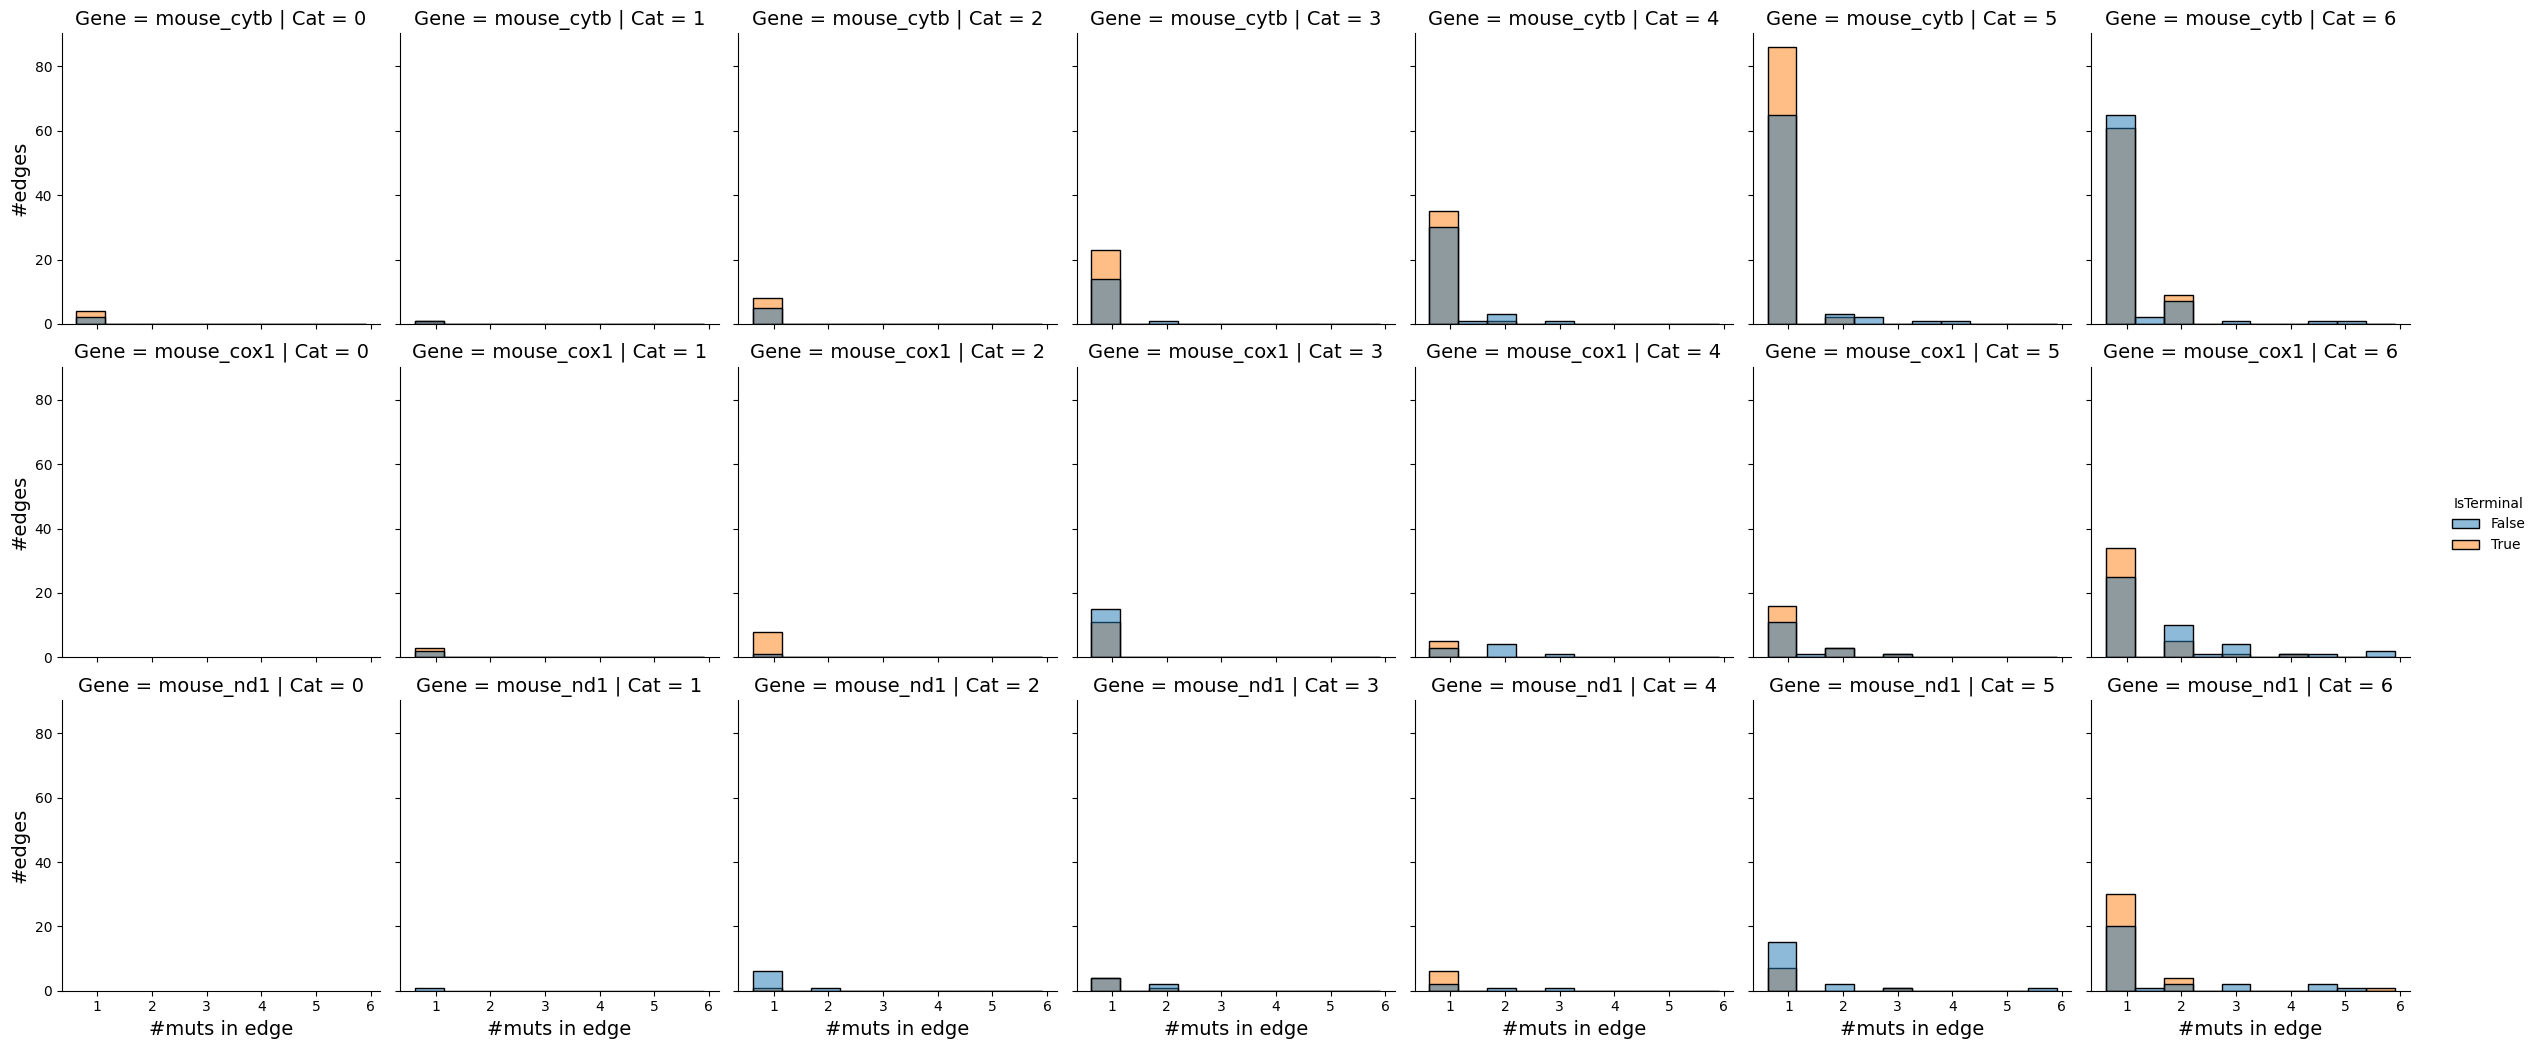

In [85]:
_df_to_plot = df[(df.ProbaFull > 0.5) & (df.Label > 0)]\
    .groupby(["Cat", "Gene", "Label", "AltNode", "IsTerminal"]).ProbaFull\
        .sum().reset_index()

g = sns.displot(
    data=_df_to_plot[_df_to_plot.Gene.str.startswith("human")],
    x="ProbaFull", hue="IsTerminal",
    col="Cat", row="Gene",
    height=3.5, bins=10,
    facet_kws=dict(
        sharey=True,
        sharex=True,
    )
)
g.set_axis_labels("#muts in edge", "#edges", size=14)
g.set_titles(size=14)
# plt.savefig("../figures/obs_muts_in_cats.pdf")
plt.show()

g = sns.displot(
    data=_df_to_plot[_df_to_plot.Gene.str.startswith("mouse")],
    x="ProbaFull", hue="IsTerminal",
    col="Cat", row="Gene",
    height=3.5, bins=10,
    facet_kws=dict(
        sharey=True,
        sharex=True,
    )
)
g.set_axis_labels("#muts in edge", "#edges", size=14)
g.set_titles(size=14)
# plt.savefig("../figures/obs_muts_in_cats.pdf")
plt.show()

In [86]:
site_muts = df[df.ProbaFull > 0.3].groupby(["Gene", "Site", "Rate", "Cat"]).ProbaFull.sum().rename("NMuts").reset_index()
site_muts.head()

,Gene,Site,Rate,Cat,NMuts
0,human_cox1,7,3.65619,6,5.984150
1,human_cox1,8,2.18163,5,8.982945
2,human_cox1,9,1.39123,3,3.990275
3,human_cox1,10,1.30675,3,21.900730
4,human_cox1,12,1.39123,3,2.995122


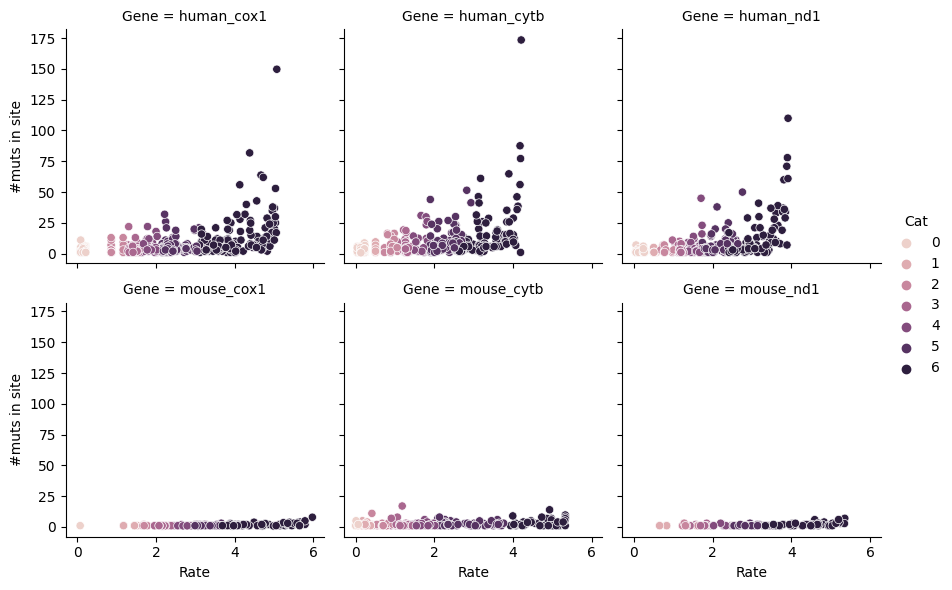

In [87]:
sns.relplot(data=site_muts, x="Rate", y="NMuts", hue="Cat",  col="Gene",col_wrap=3, sizes=(0, 160), height=3).set_axis_labels("Rate", "#muts in site")
plt.show()

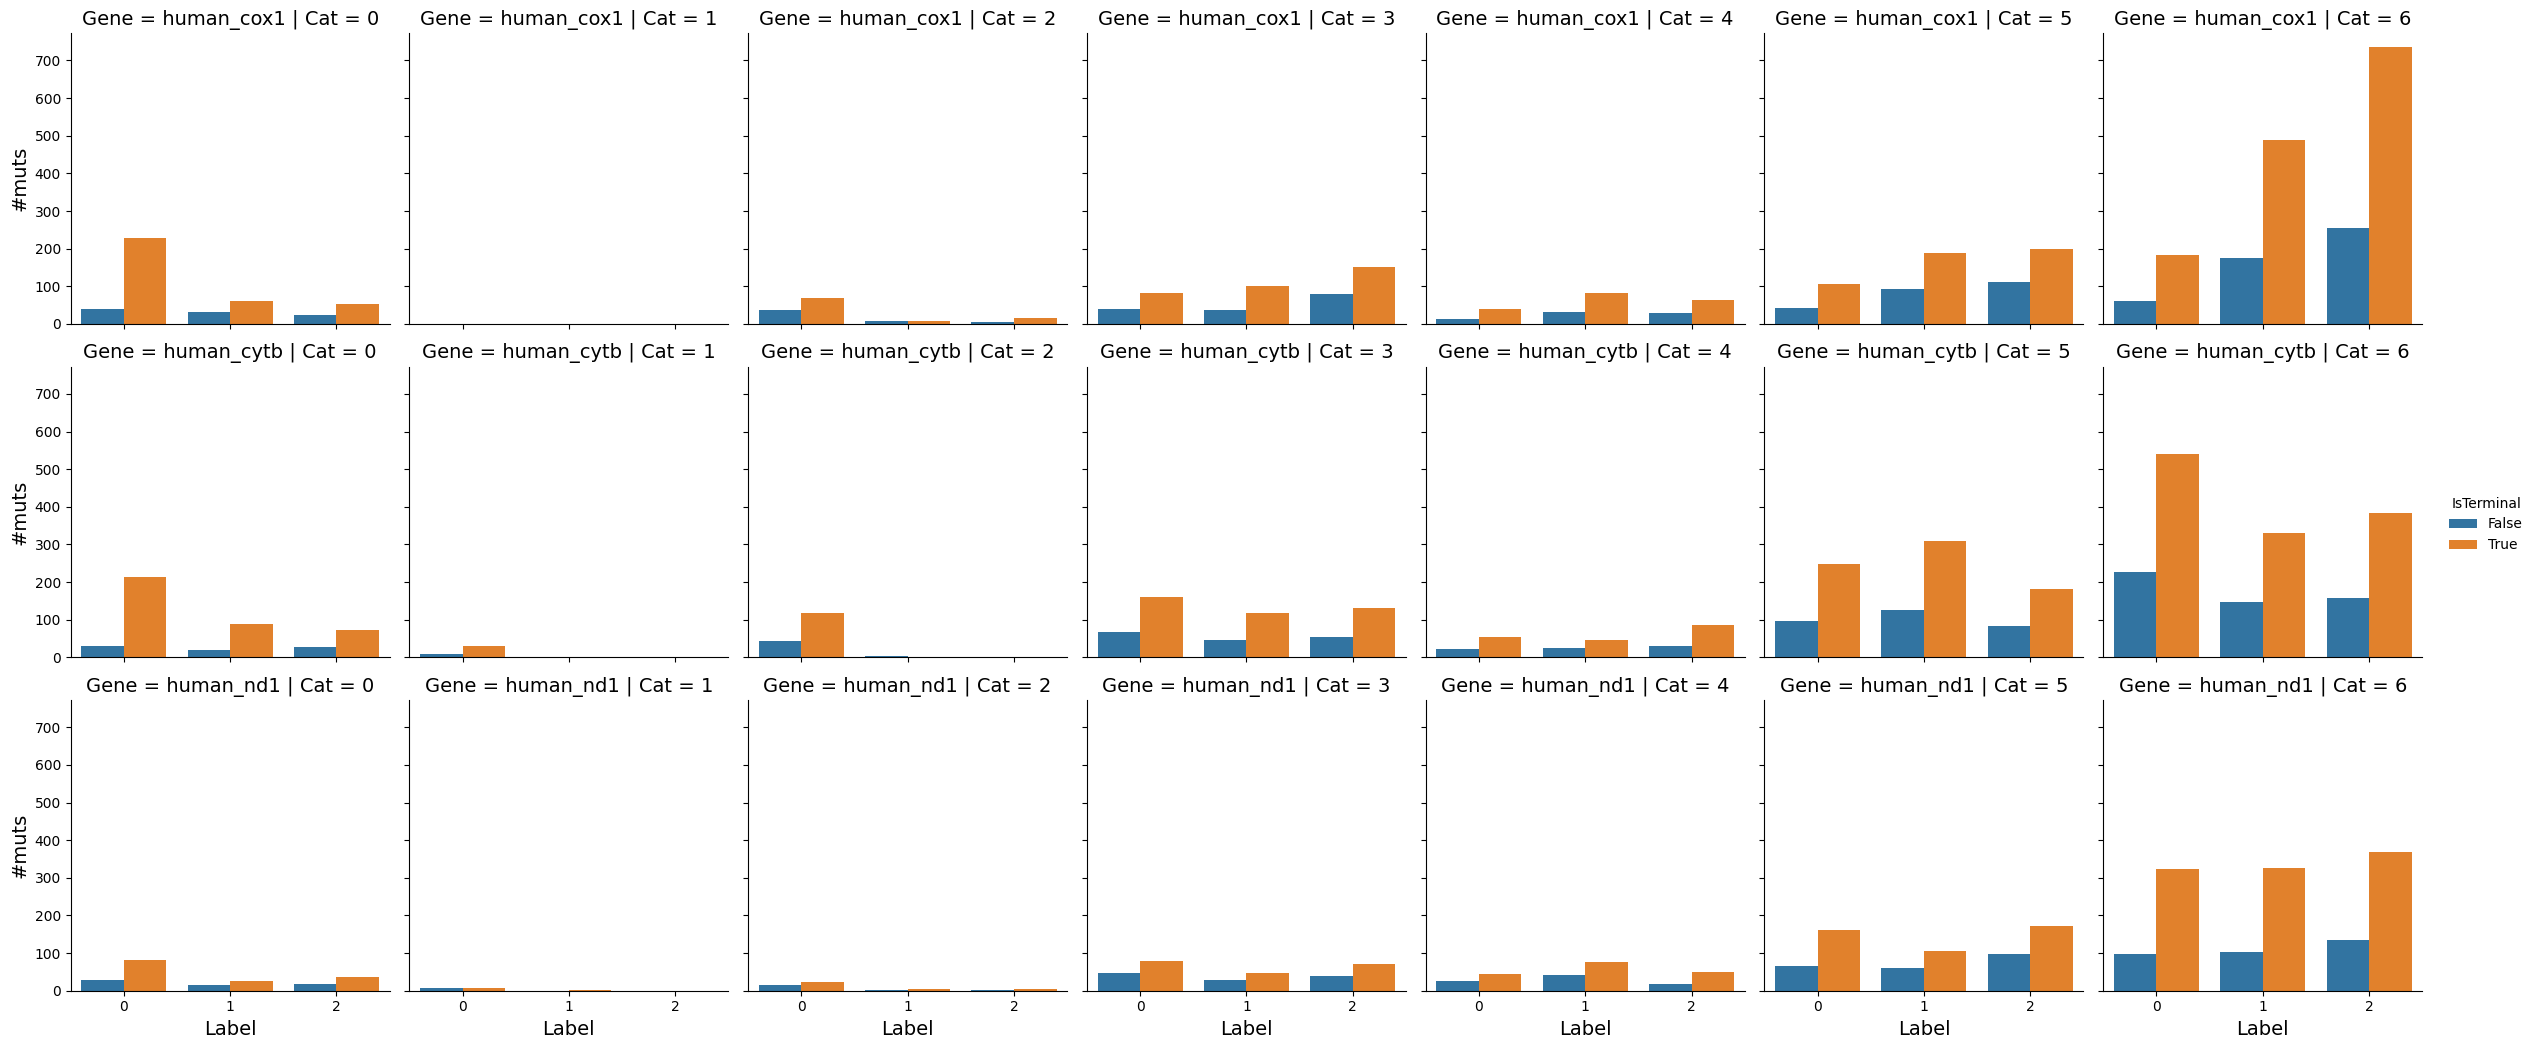

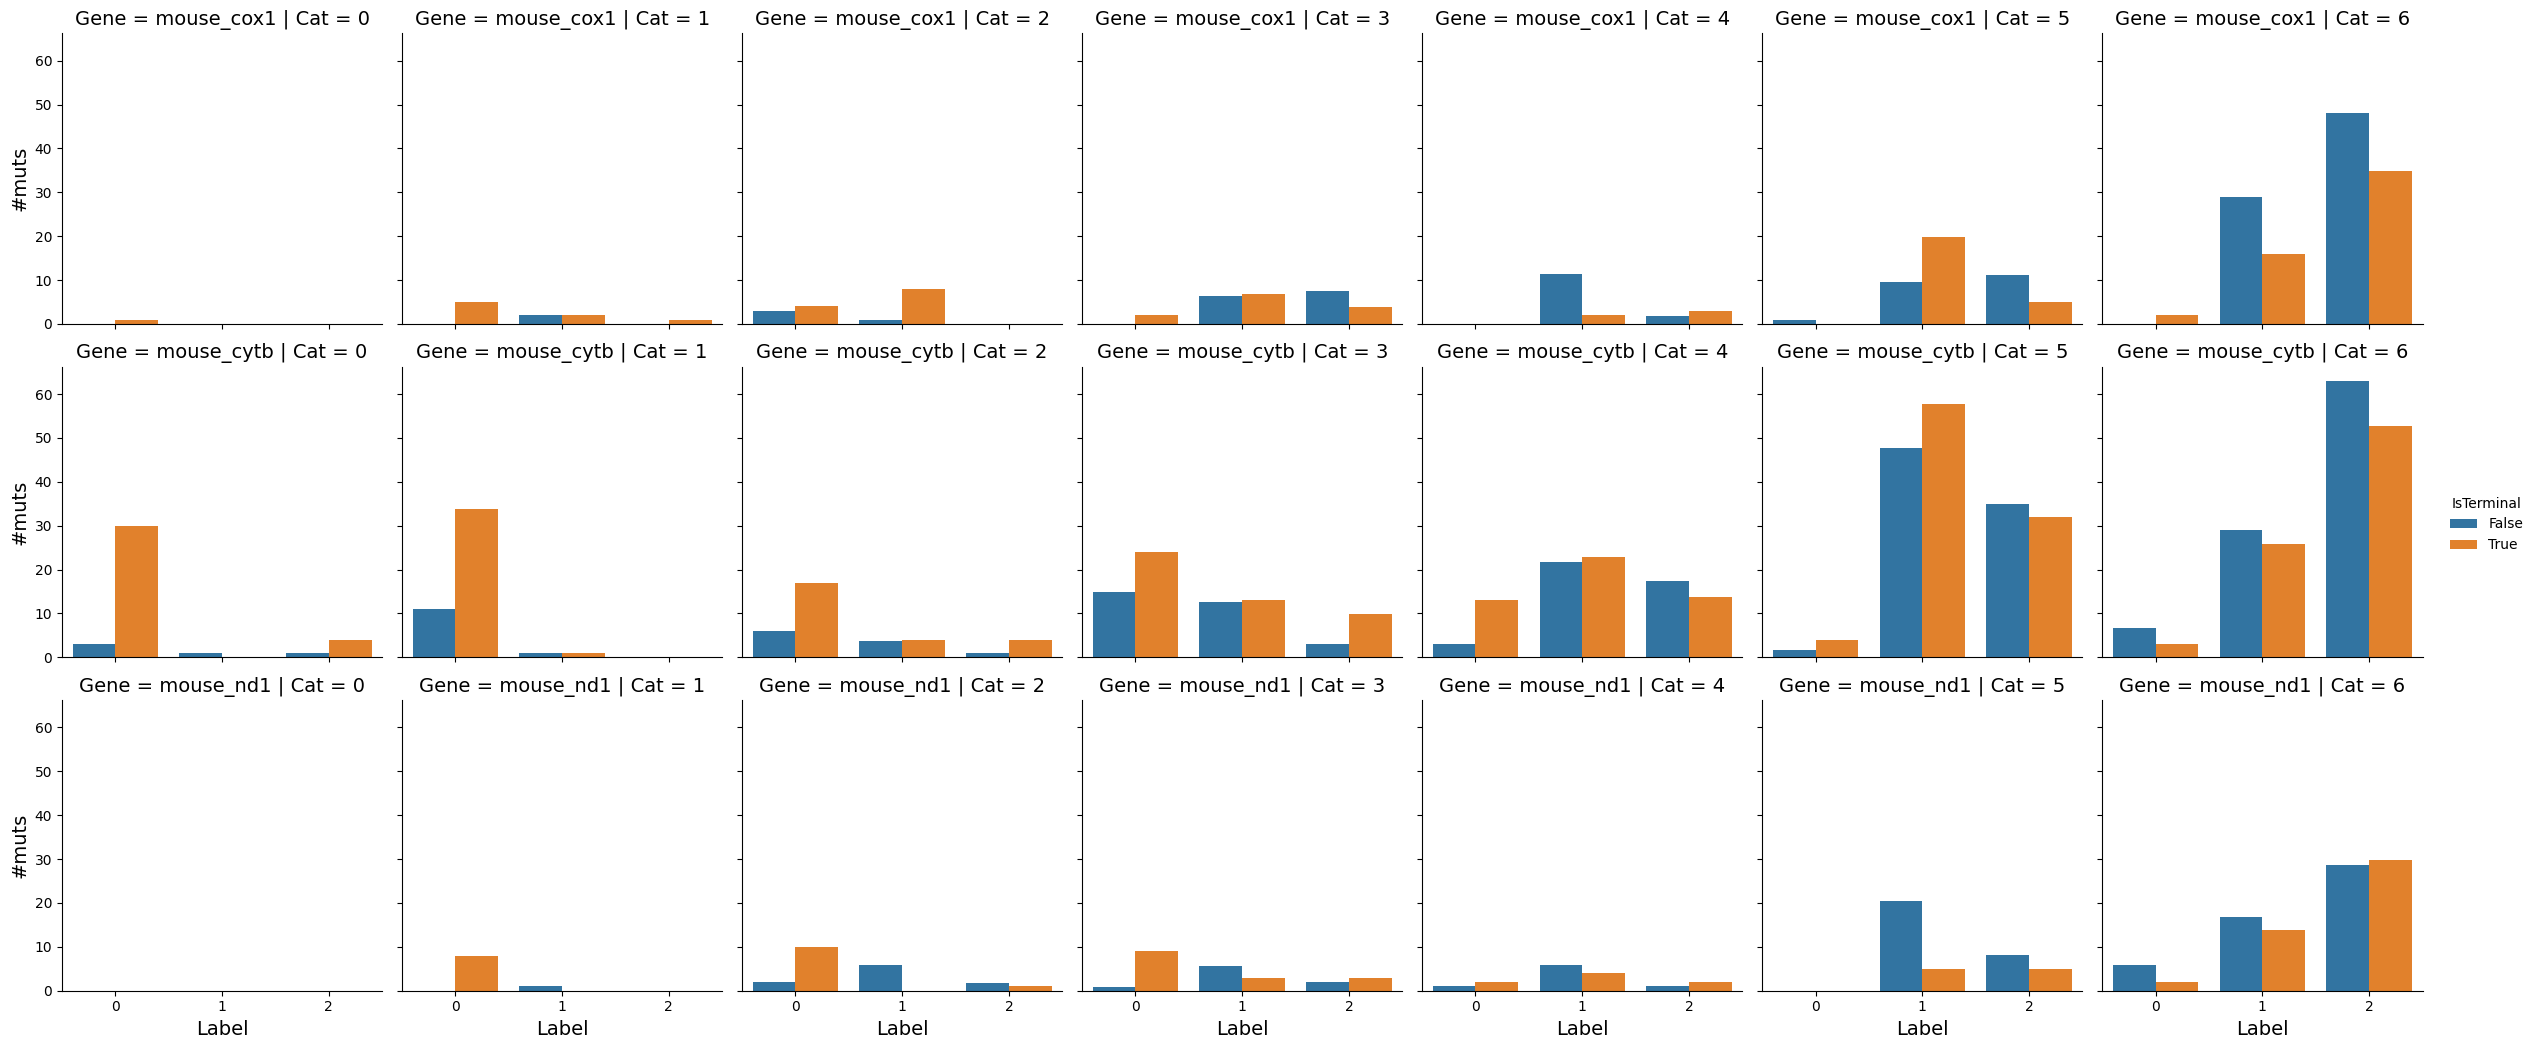

In [88]:
g = sns.catplot(
    data=df[(df.ProbaFull > 0.3) & (df.Gene.str.startswith('human'))]\
        .groupby(["Cat", "Gene", "Label", "IsTerminal"]).ProbaFull.sum().reset_index(),
    x="Label", y="ProbaFull", hue="IsTerminal",
    col="Cat", row="Gene",
    kind="bar", height=3.5,
    sharey=True,
)
g.set_axis_labels("Label", "#muts", size=14)
g.set_titles(size=14)
# plt.savefig("../figures/obs_muts_in_cats.pdf")
plt.show()

g = sns.catplot(
    data=df[(df.ProbaFull > 0.3) & (df.Gene.str.startswith('mouse'))]\
        .groupby(["Cat", "Gene", "Label", "IsTerminal"]).ProbaFull.sum().reset_index(),
    x="Label", y="ProbaFull", hue="IsTerminal",
    col="Cat", row="Gene",
    kind="bar", height=3.5,
    sharey=True,
)
g.set_axis_labels("Label", "#muts", size=14)
g.set_titles(size=14)
# plt.savefig("../figures/obs_muts_in_cats.pdf")
plt.show()

### ALN

In [89]:
def get_variability_rate(aln):
    seq = []
    n = len(aln)
    for column in zip(*aln):
        m = Counter(column).most_common()[0][1]
        seq.append(m / n)
    return seq

In [ ]:
## Check 0 category of rates (it must be invariant)
for lbl, data in zip(['human_cytb', 'human_cox1', 'human_nd1', 'mouse_cytb', 'mouse_cox1', 'mouse_nd1'], 
                     [human_cytb, human_cox1, human_nd1, mouse_cytb, mouse_cox1, mouse_nd1]):
    cats = data['rate']['Cat'].values
    vrate = get_variability_rate(data['aln'])
    print(lbl)
    assert len(cats) == len(vrate)
    for site,(c, vr) in enumerate(zip(cats, vrate), 1):
        if c == 0 and vr != 1 or c != 0 and vr == 1:
            print(f"cat = {c}, vrate = {vr:.2f} on site {site}")
    
    print()

### check strand in image

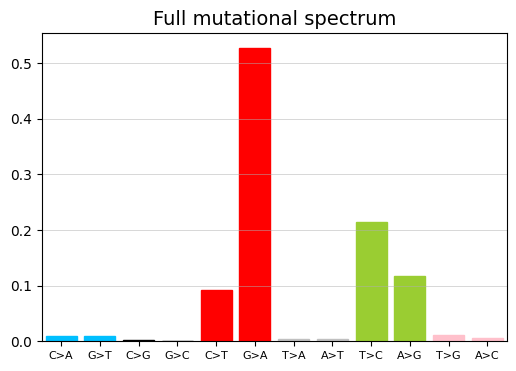

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


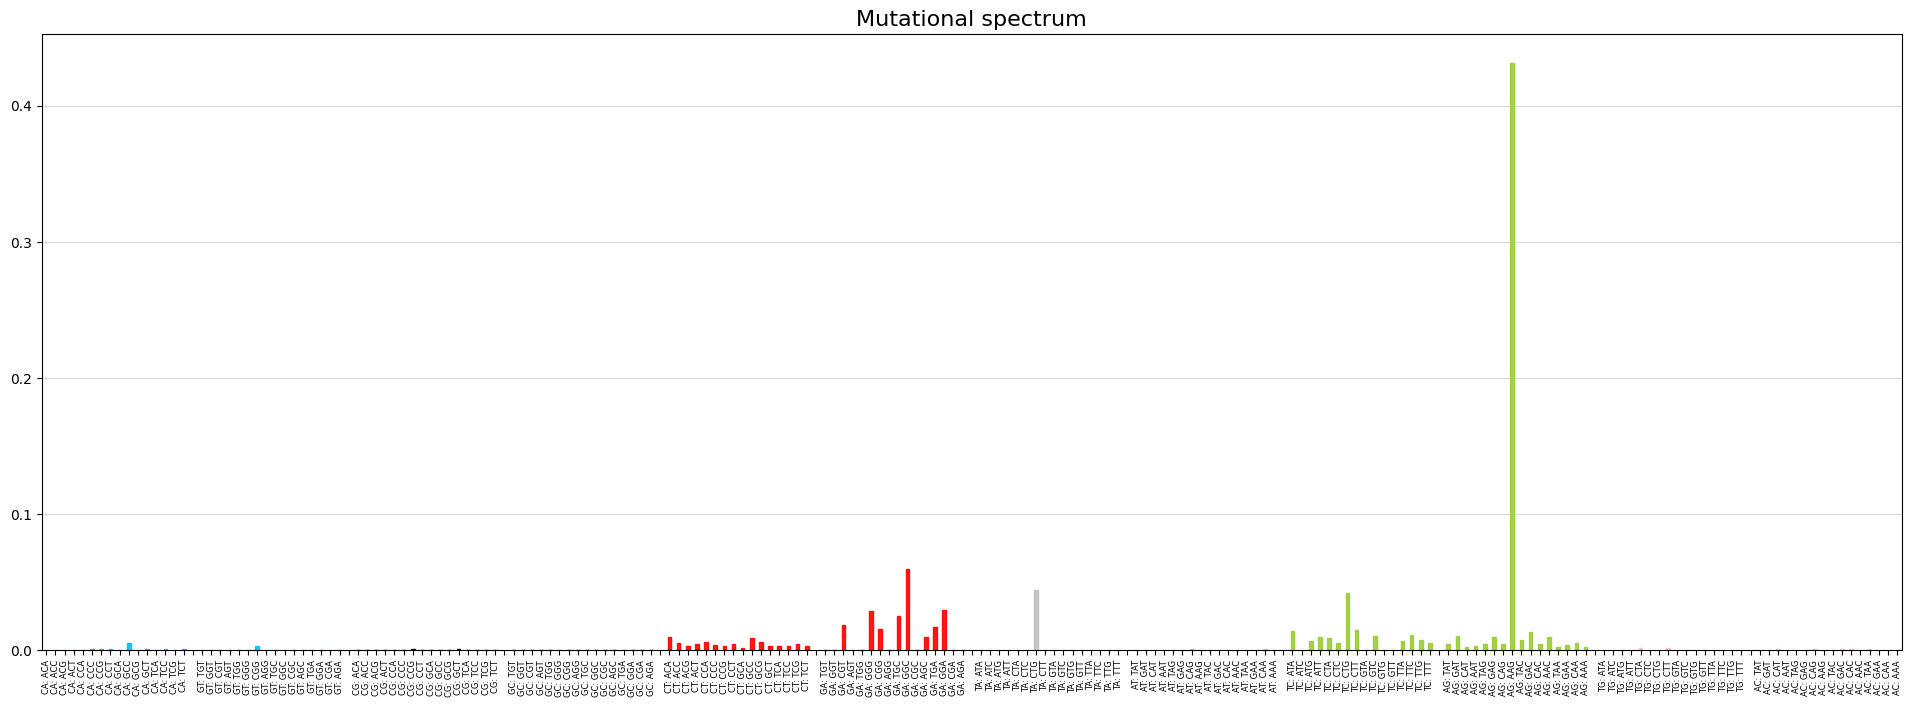

In [18]:
plot_mutspec12(human_cytb["ms_rec12"])
plot_mutspec192(human_cytb["ms_rec192"], labels_style="long")

**light**

## Estimate mutations under selection

In [4]:
def count_diff(df, nreplics):
    nzeros = (df.ObsNum_sim == 0).sum()
    nplus = ((df.ObsNum_rec.round() > df.ObsNum_sim) & (df.ObsNum_sim != 0)).sum()
    nminus = ((df.ObsNum_rec.round() < df.ObsNum_sim) & (df.ObsNum_sim != 0)).sum()
    n = nzeros + nplus + nminus
    n_eq = nreplics - n
    return pd.Series(dict(nzeros=nzeros, n_eq=n_eq, nplus=nplus, nminus=nminus, zerosFr=nzeros/n, plusFr=nplus/n, minusFr=nminus/n))


def get_significance(df):
    a = df.nplus.item()
    b = df.nminus.item()
    n = a + b
    if n > 5:
        pval = binom_test(a, n)
    else:
        pval = np.nan
    return pval

In [5]:
pcutoff = 0.3
nreplics=100

for lbl, data in zip(['human_cytb', 'human_cox1', 'human_nd1', 'mouse_cytb', 'mouse_cox1', 'mouse_nd1'], 
                     [human_cytb, human_cox1, human_nd1, mouse_cytb, mouse_cox1, mouse_nd1]):
    # drop low-proba mutations from ObsNum (simple replacing)
    _ms_rec192 = data["ms_rec192"].copy()
    high_proba_muts_syn = data["mutations"][
        (data["mutations"].ProbaFull > pcutoff) & 
        (data["mutations"].Label > 0) &
        (data["mutations"].AltNode.str.startswith("Node"))
    ]
    high_proba_obs = high_proba_muts_syn.groupby("Mut").ProbaFull.sum().to_dict()
    _ms_rec192["ObsNum"] = _ms_rec192["Mut"].map(high_proba_obs).fillna(0.)

    # merge rec and sim
    df = _ms_rec192.merge(data["ms_sim192"], on="Mut", suffixes=["_rec", "_sim"])
    # df["diff"] = df["ObsNum_rec"] - df["ObsNum_sim"]
    data["both"] = df
    gr = df.groupby("Mut")
    
    diff_stats = gr.agg({"ObsNum_rec": "mean", "ObsNum_sim": "mean"})\
        .rename(columns=lambda x: x+'_mean')

    # diff_stats = gr["diff"].agg(
    #     ["mean", "std", lambda x: bootstrap((x,), np.mean).confidence_interval])
    # diff_stats["low"] = diff_stats["<lambda_0>"].apply(lambda x: x.low)
    # diff_stats["high"] = diff_stats["<lambda_0>"].apply(lambda x: x.high)
    # diff_stats.drop("<lambda_0>", axis=1, inplace=True)
    
    _diff_stats2 = gr.apply(partial(count_diff, nreplics=nreplics))
    diff_stats = diff_stats.merge(_diff_stats2, left_index=True, right_index=True)
    del _diff_stats2
    diff_stats["p-value"] = diff_stats["n_eq"] / (nreplics + 1)
    # diff_stats["p-value"] = diff_stats.apply(get_significance, axis=1)
    # diff_stats["p-value-adj"] = multipletests(diff_stats["p-value"])[1]

    data["diff_stats"] = diff_stats

    # extract sbs under selection
    # pval_cutoff = 0.15 if lbl.startswith("human") else 0.05
    pval_cutoff = 0.05
    diff_stats_filtered = diff_stats[
        (diff_stats["ObsNum_rec_mean"] > 0) & 
        (diff_stats["p-value"] < pval_cutoff) & 
        (diff_stats["zerosFr"] < 0.95)
    ]
    data["diff_stats_filtered"] = diff_stats_filtered
    data["muts_positive"] = diff_stats_filtered[
        (diff_stats_filtered["nplus"] > diff_stats_filtered["nminus"])].index.values
    data["muts_negative"] = diff_stats_filtered[
        (diff_stats_filtered["nplus"] < diff_stats_filtered["nminus"])].index.values


### Raw tables

In [8]:
human_cox1["diff_stats_filtered"]

,ObsNum_rec_mean,ObsNum_sim_mean,nzeros,n_eq,nplus,nminus,zerosFr,plusFr,minusFr,p-value
Mut,,,,,,,,,,
A[A>G]C,18.900314,8.53,0.0,0.0,100.0,0.0,0.000000,1.000000,0.000000,0.000000
A[C>T]A,30.695800,12.95,0.0,0.0,100.0,0.0,0.000000,1.000000,0.000000,0.000000
A[G>A]C,8.930849,13.96,0.0,4.0,9.0,87.0,0.000000,0.093750,0.906250,0.039604
A[G>A]G,10.979647,3.35,5.0,0.0,95.0,0.0,0.050000,0.950000,0.000000,0.000000
A[T>C]G,2.992690,11.25,0.0,0.0,0.0,100.0,0.000000,0.000000,1.000000,0.000000
A[T>C]T,22.848223,20.36,0.0,4.0,71.0,25.0,0.000000,0.739583,0.260417,0.039604
C[A>G]C,15.843960,5.03,1.0,0.0,99.0,0.0,0.010000,0.990000,0.000000,0.000000
C[A>G]G,15.960753,9.33,0.0,0.0,98.0,2.0,0.000000,0.980000,0.020000,0.000000
C[C>A]G,3.992370,1.63,20.0,3.0,76.0,1.0,0.206186,0.783505,0.010309,0.029703


In [19]:
human_cytb["diff_stats_filtered"]

,ObsNum_rec_mean,ObsNum_sim_mean,nzeros,n_eq,nplus,nminus,zerosFr,plusFr,minusFr,p-value
Mut,,,,,,,,,,
A[A>G]C,14.247260,2.60,8.0,0.0,92.0,0.0,0.080000,0.920000,0.000000,0.000000
A[C>T]A,33.731001,17.04,0.0,0.0,100.0,0.0,0.000000,1.000000,0.000000,0.000000
A[C>T]T,17.017371,21.93,0.0,2.0,14.0,84.0,0.000000,0.142857,0.857143,0.019802
A[G>A]C,3.766285,21.01,0.0,0.0,0.0,100.0,0.000000,0.000000,1.000000,0.000000
A[T>C]T,31.533347,40.05,0.0,1.0,9.0,90.0,0.000000,0.090909,0.909091,0.009901
C[A>G]A,14.124593,7.51,0.0,1.0,98.0,1.0,0.000000,0.989899,0.010101,0.009901
C[A>G]C,10.304568,2.16,10.0,0.0,90.0,0.0,0.100000,0.900000,0.000000,0.000000
C[A>T]G,1.941149,0.49,59.0,4.0,35.0,2.0,0.614583,0.364583,0.020833,0.039604
C[C>T]A,21.664667,9.53,0.0,0.0,100.0,0.0,0.000000,1.000000,0.000000,0.000000


In [20]:
human_nd1["diff_stats_filtered"]

,ObsNum_rec_mean,ObsNum_sim_mean,nzeros,n_eq,nplus,nminus,zerosFr,plusFr,minusFr,p-value
Mut,,,,,,,,,,
A[A>G]A,5.990545,1.69,22.0,1.0,77.0,0.0,0.222222,0.777778,0.000000,0.009901
A[A>G]C,12.830338,7.28,0.0,2.0,96.0,2.0,0.000000,0.979592,0.020408,0.019802
A[C>T]A,9.986471,5.38,0.0,0.0,95.0,5.0,0.000000,0.950000,0.050000,0.000000
A[C>T]C,12.985133,2.40,13.0,0.0,87.0,0.0,0.130000,0.870000,0.000000,0.000000
A[C>T]G,8.985620,5.35,1.0,5.0,88.0,6.0,0.010526,0.926316,0.063158,0.049505
A[C>T]T,3.990459,6.42,0.0,5.0,20.0,75.0,0.000000,0.210526,0.789474,0.049505
A[G>A]C,8.956991,3.86,2.0,1.0,94.0,3.0,0.020202,0.949495,0.030303,0.009901
A[G>A]T,9.919966,4.07,4.0,1.0,95.0,0.0,0.040404,0.959596,0.000000,0.009901
A[T>C]G,9.991139,4.07,1.0,1.0,97.0,1.0,0.010101,0.979798,0.010101,0.009901


In [9]:
mouse_cox1["diff_stats_filtered"]

,ObsNum_rec_mean,ObsNum_sim_mean,nzeros,n_eq,nplus,nminus,zerosFr,plusFr,minusFr,p-value
Mut,,,,,,,,,,
A[A>G]C,1.942275,0.09,91.0,0.0,9.0,0.0,0.910000,0.090000,0.000000,0.000000
A[C>T]C,4.562076,0.57,52.0,0.0,48.0,0.0,0.520000,0.480000,0.000000,0.000000
A[C>T]T,5.627340,0.75,45.0,0.0,55.0,0.0,0.450000,0.550000,0.000000,0.000000
A[T>C]C,5.680125,0.26,76.0,0.0,24.0,0.0,0.760000,0.240000,0.000000,0.000000
C[A>G]T,1.916604,0.08,93.0,1.0,6.0,0.0,0.939394,0.060606,0.000000,0.009901
C[C>T]C,3.917821,0.45,62.0,0.0,38.0,0.0,0.620000,0.380000,0.000000,0.000000
C[T>C]A,3.696959,0.33,69.0,0.0,31.0,0.0,0.690000,0.310000,0.000000,0.000000
C[T>C]C,1.918472,0.27,74.0,1.0,25.0,0.0,0.747475,0.252525,0.000000,0.009901
C[T>C]G,4.756331,0.36,69.0,0.0,31.0,0.0,0.690000,0.310000,0.000000,0.000000


In [10]:
mouse_cytb["diff_stats_filtered"]

,ObsNum_rec_mean,ObsNum_sim_mean,nzeros,n_eq,nplus,nminus,zerosFr,plusFr,minusFr,p-value
Mut,,,,,,,,,,
A[A>G]C,2.967043,0.65,48.0,2.0,50.0,0.0,0.489796,0.510204,0.000000,0.019802
A[C>T]C,8.382723,1.28,28.0,0.0,72.0,0.0,0.280000,0.720000,0.000000,0.000000
A[G>A]C,5.920021,1.02,35.0,0.0,65.0,0.0,0.350000,0.650000,0.000000,0.000000
A[T>C]A,11.202603,2.38,10.0,0.0,90.0,0.0,0.100000,0.900000,0.000000,0.000000
A[T>C]C,2.667484,0.46,64.0,1.0,34.0,1.0,0.646465,0.343434,0.010101,0.009901
A[T>C]T,5.942638,1.64,18.0,1.0,81.0,0.0,0.181818,0.818182,0.000000,0.009901
C[A>C]T,1.992932,0.13,88.0,1.0,11.0,0.0,0.888889,0.111111,0.000000,0.009901
C[A>G]A,1.999970,0.55,52.0,5.0,42.0,1.0,0.547368,0.442105,0.010526,0.049505
C[A>G]C,2.955285,0.27,77.0,0.0,23.0,0.0,0.770000,0.230000,0.000000,0.000000


In [11]:
mouse_nd1["diff_stats_filtered"]

,ObsNum_rec_mean,ObsNum_sim_mean,nzeros,n_eq,nplus,nminus,zerosFr,plusFr,minusFr,p-value
Mut,,,,,,,,,,
A[C>T]A,3.910827,0.34,74.0,0.0,26.0,0.0,0.740000,0.260000,0.0,0.000000
A[C>T]G,1.979491,0.20,81.0,1.0,18.0,0.0,0.818182,0.181818,0.0,0.009901
A[C>T]T,9.540548,0.89,41.0,0.0,59.0,0.0,0.410000,0.590000,0.0,0.000000
A[G>A]T,3.668348,0.21,80.0,0.0,20.0,0.0,0.800000,0.200000,0.0,0.000000
A[T>C]A,3.918745,0.37,69.0,0.0,31.0,0.0,0.690000,0.310000,0.0,0.000000
C[C>T]A,4.622678,0.46,63.0,0.0,37.0,0.0,0.630000,0.370000,0.0,0.000000
C[T>C]A,6.288093,1.09,30.0,0.0,70.0,0.0,0.300000,0.700000,0.0,0.000000
C[T>C]C,2.928234,0.40,64.0,0.0,36.0,0.0,0.640000,0.360000,0.0,0.000000
C[T>C]T,4.437932,0.78,44.0,1.0,55.0,0.0,0.444444,0.555556,0.0,0.009901


### Plot sbs under selection

human_cytb


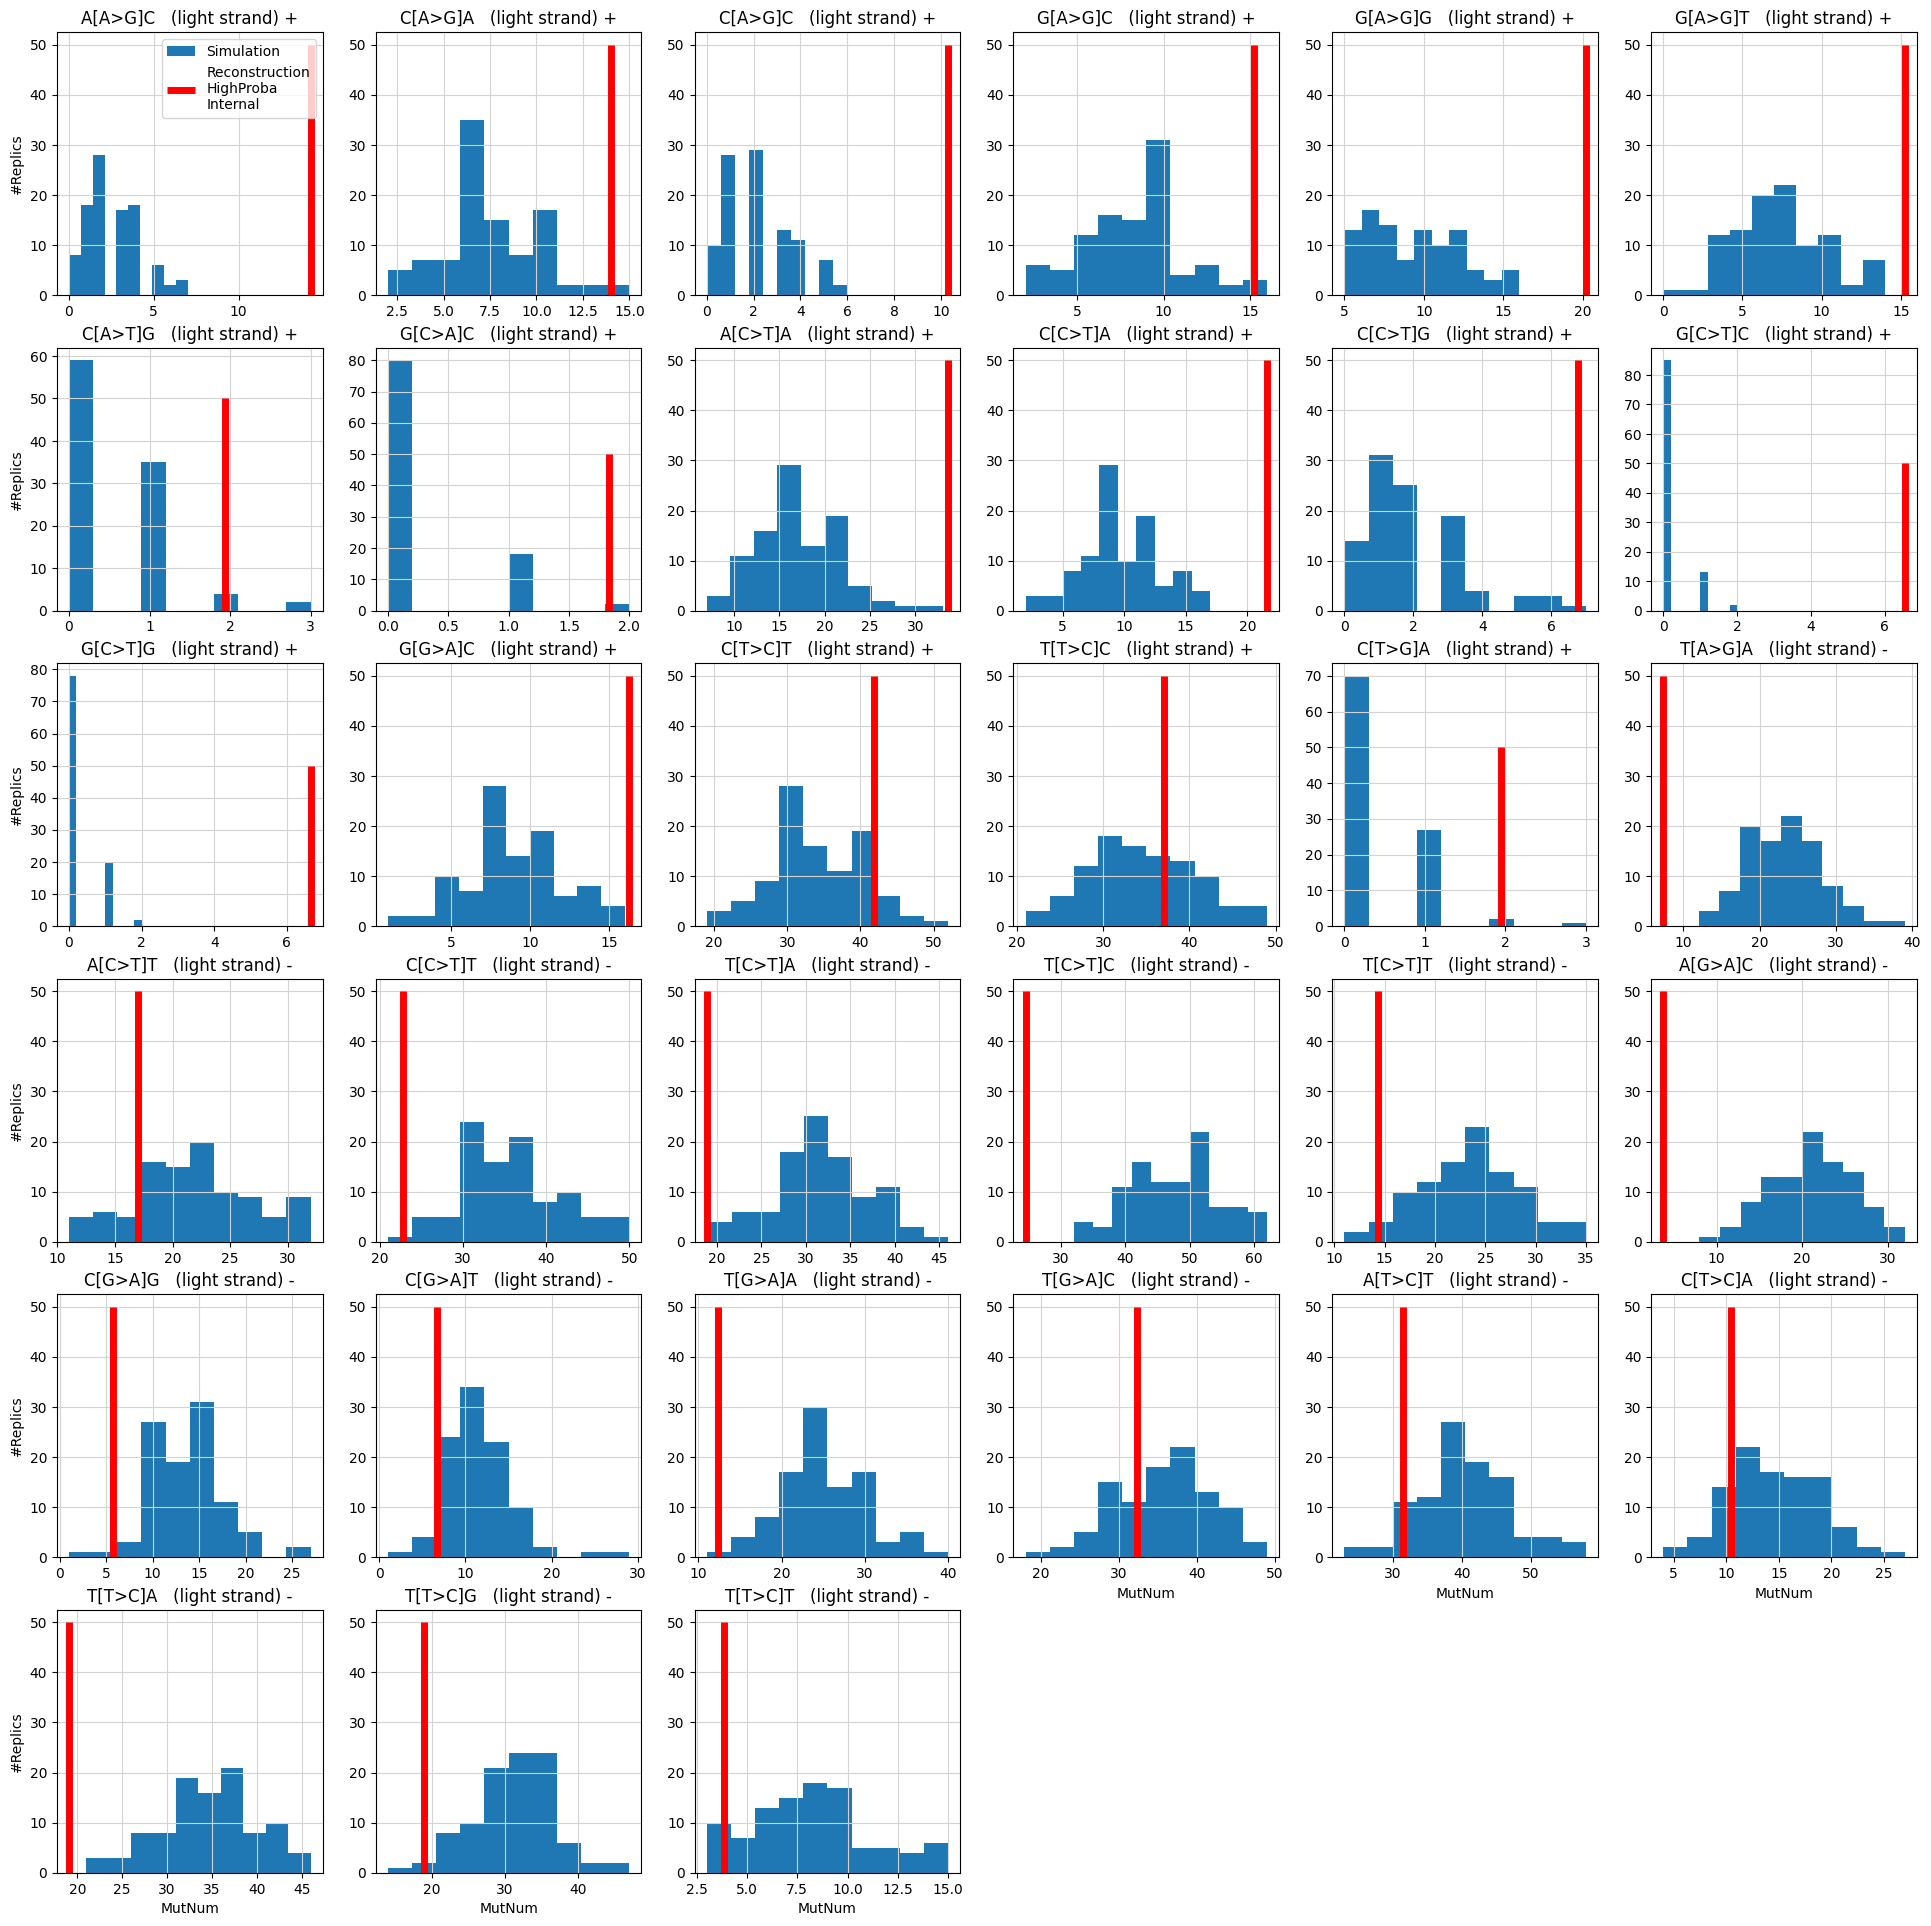

human_cox1


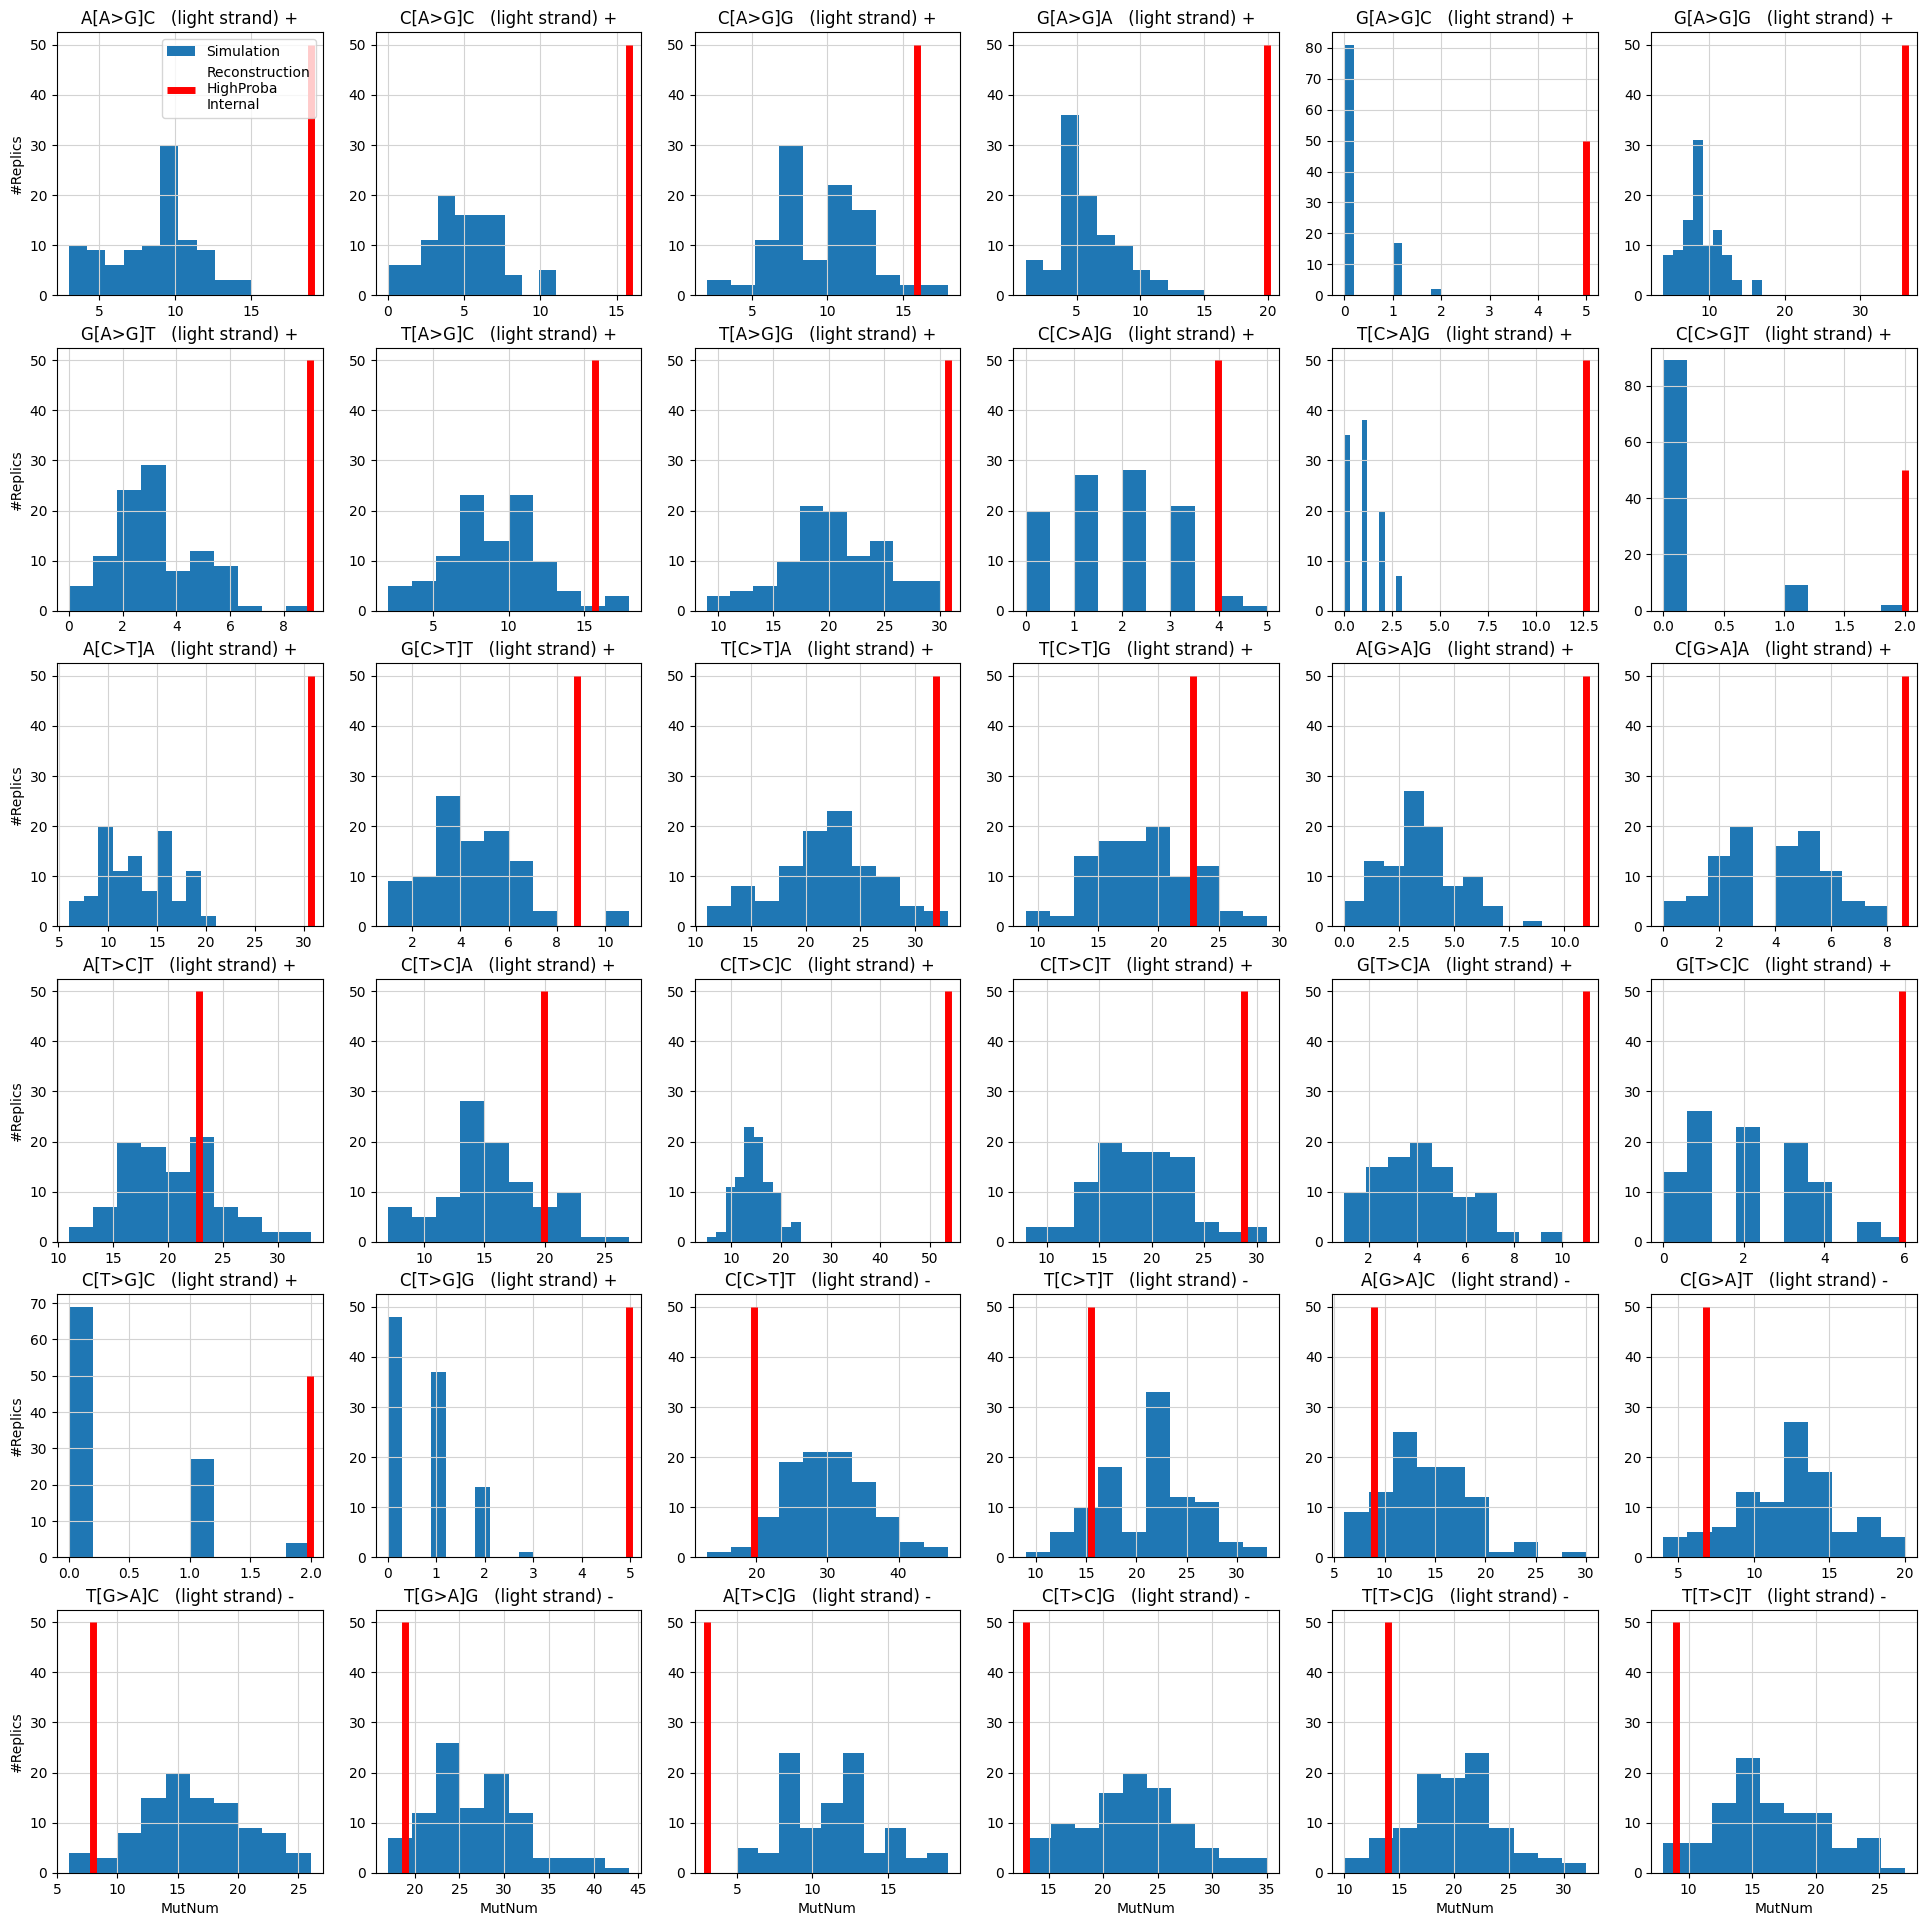

human_nd1


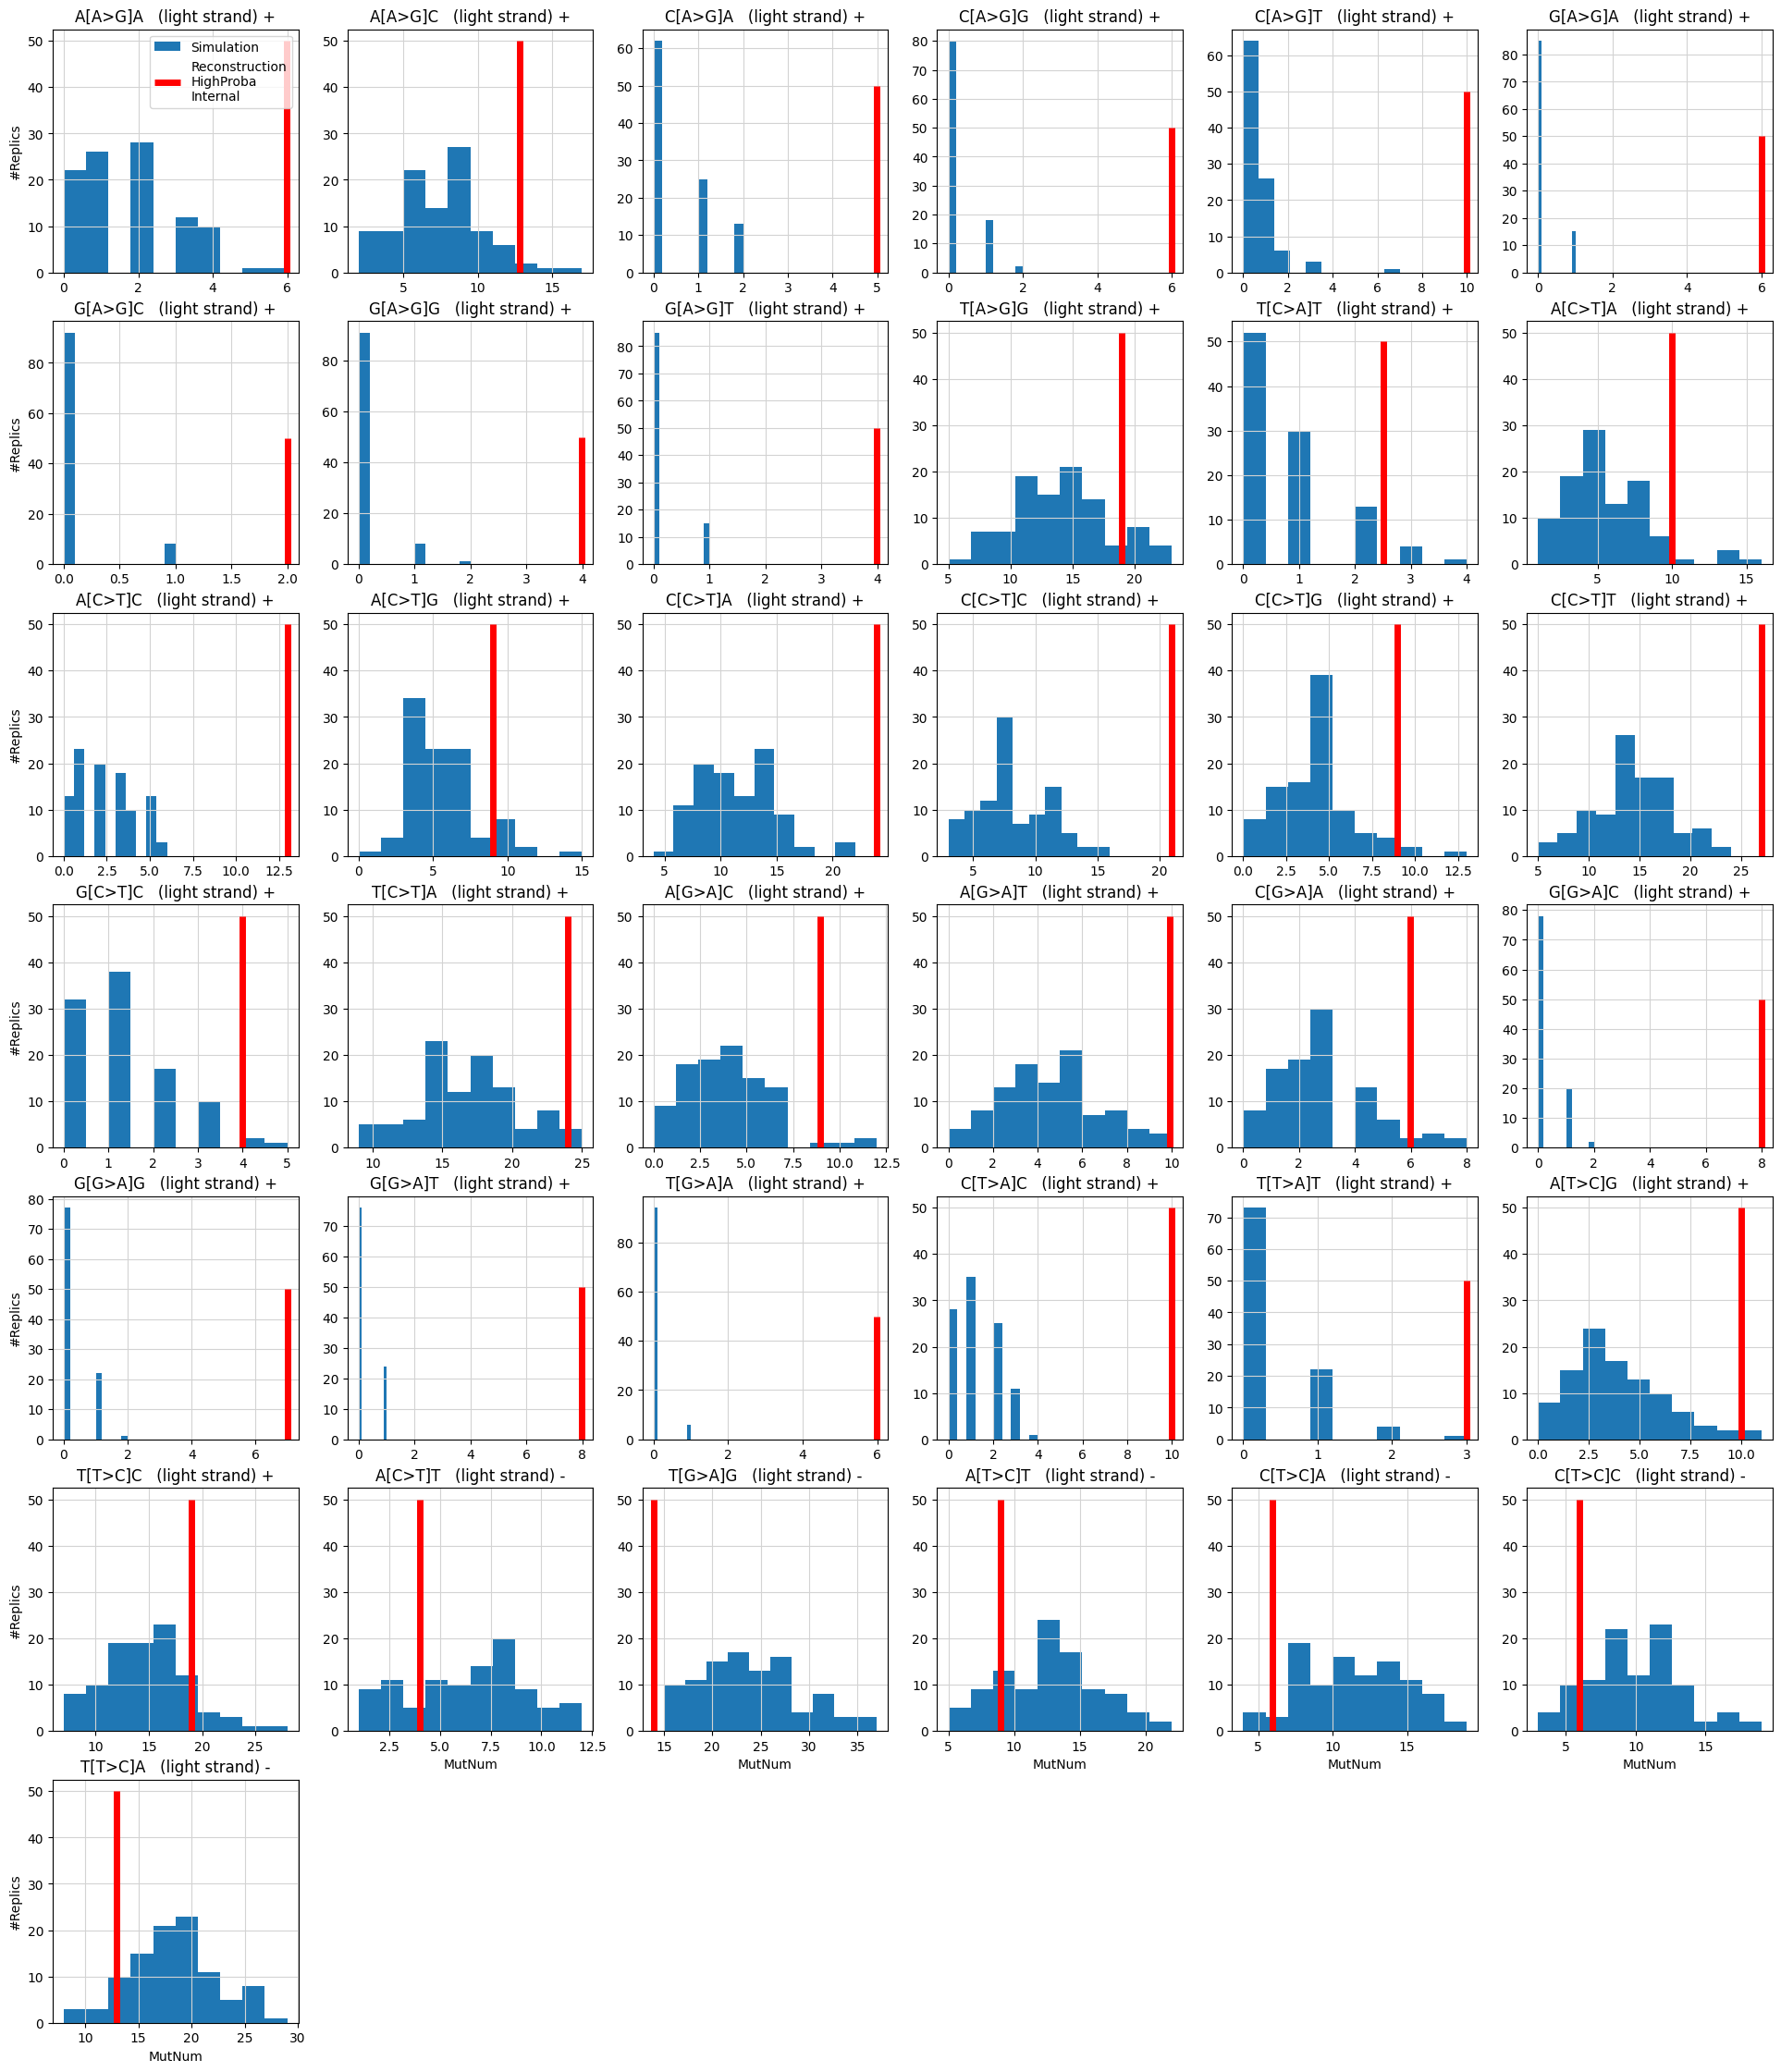

mouse_cytb


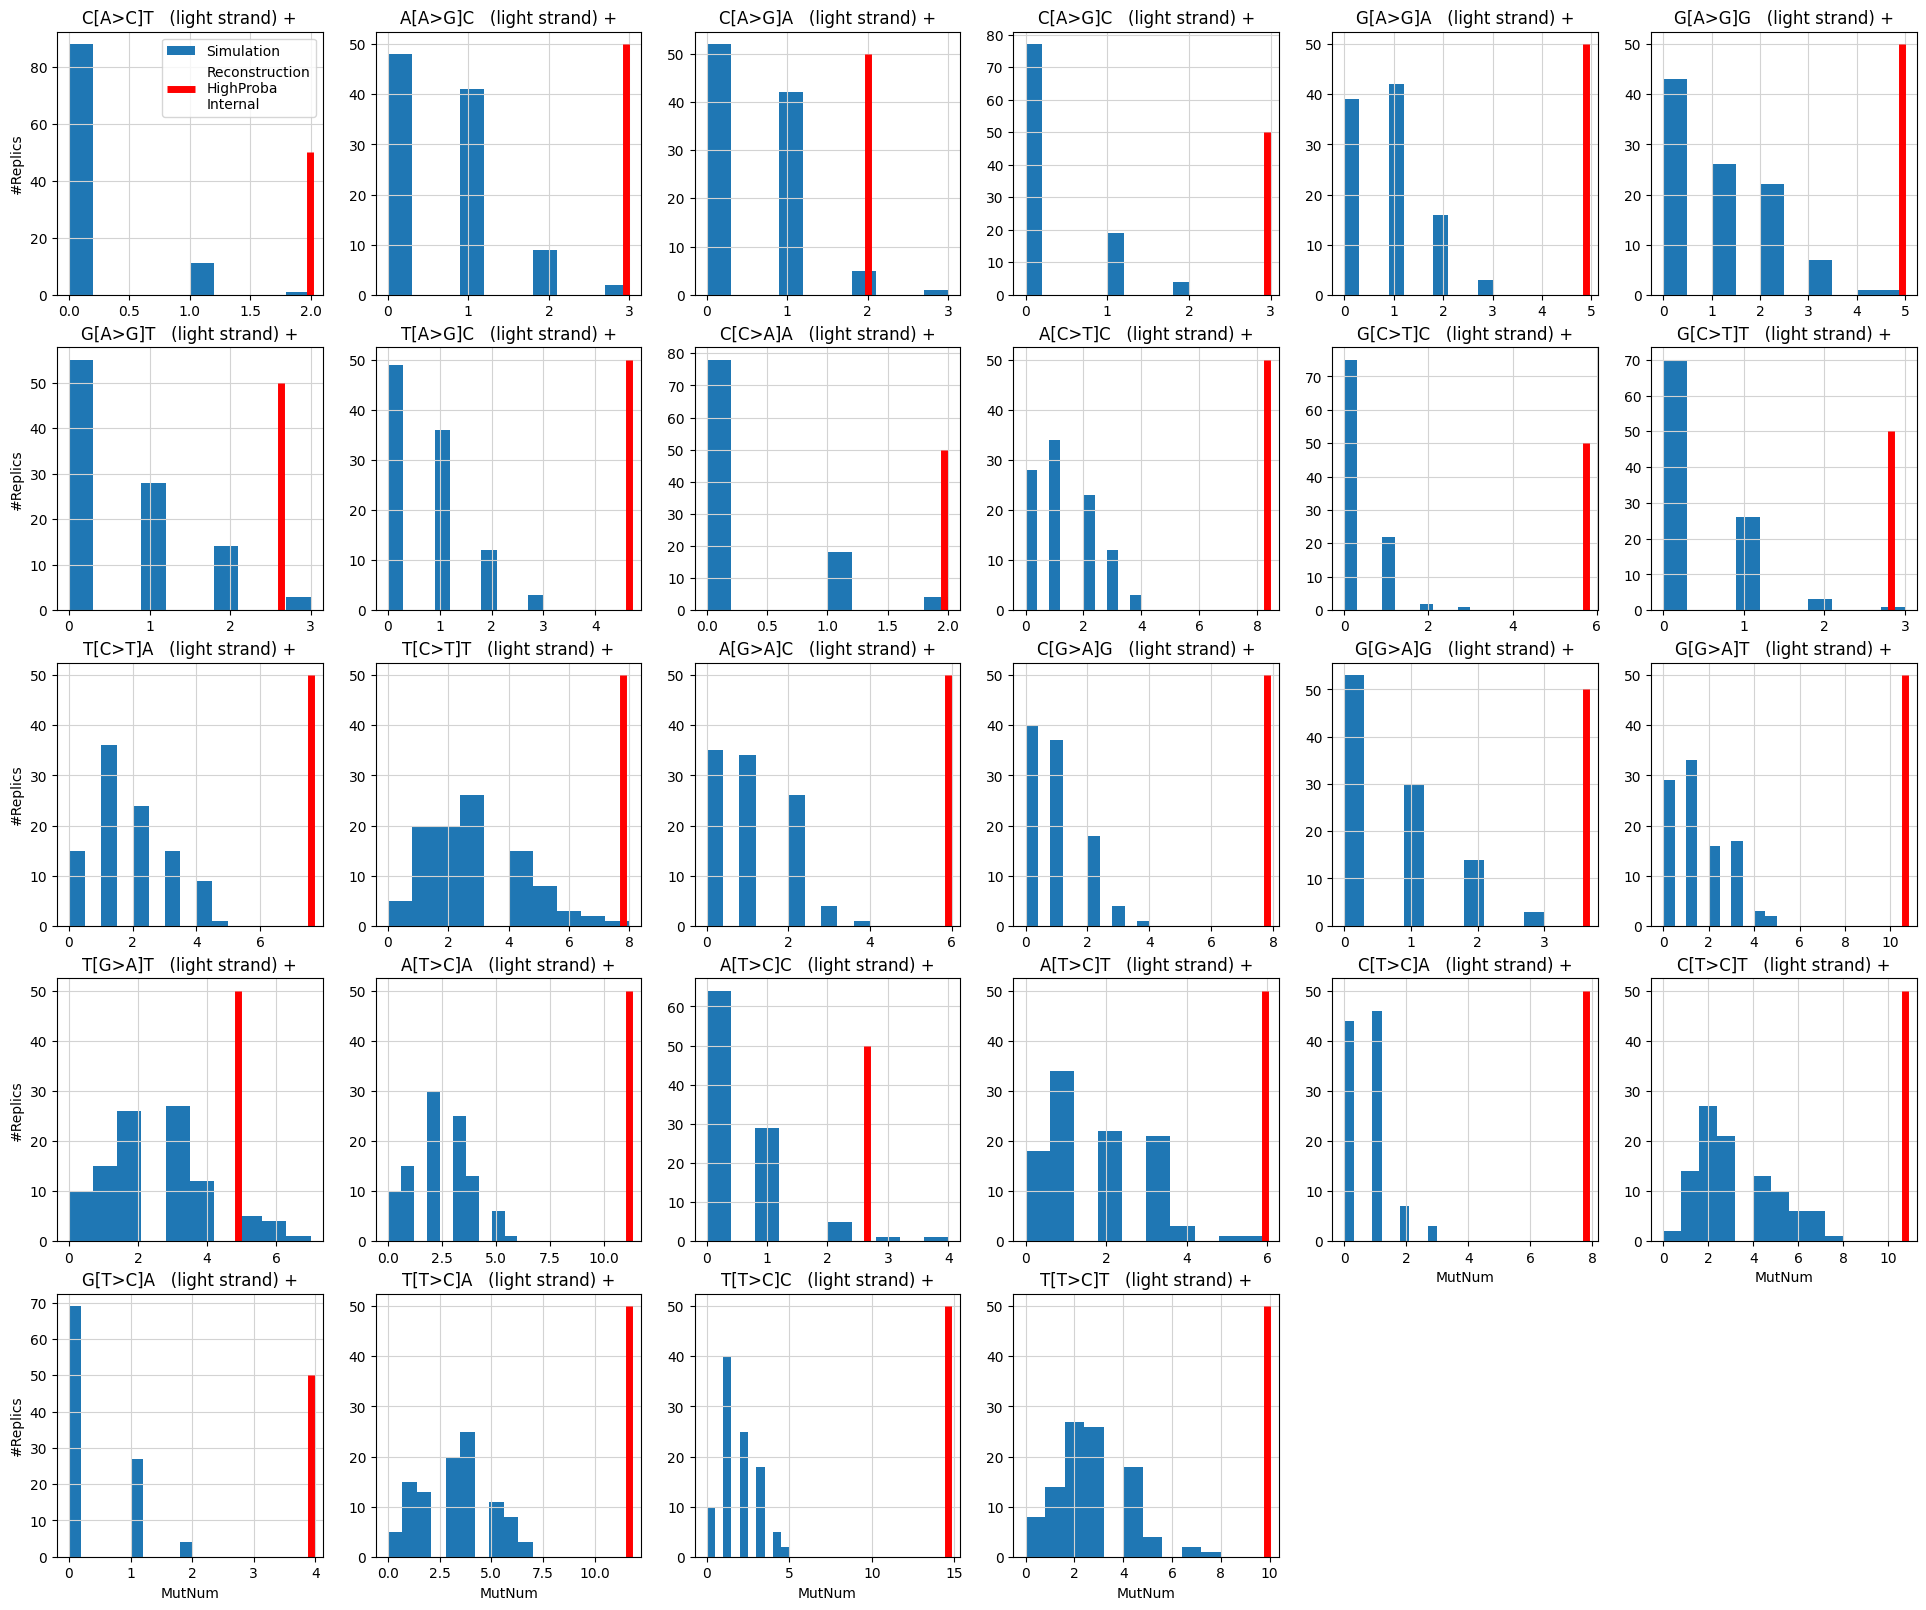

mouse_cox1


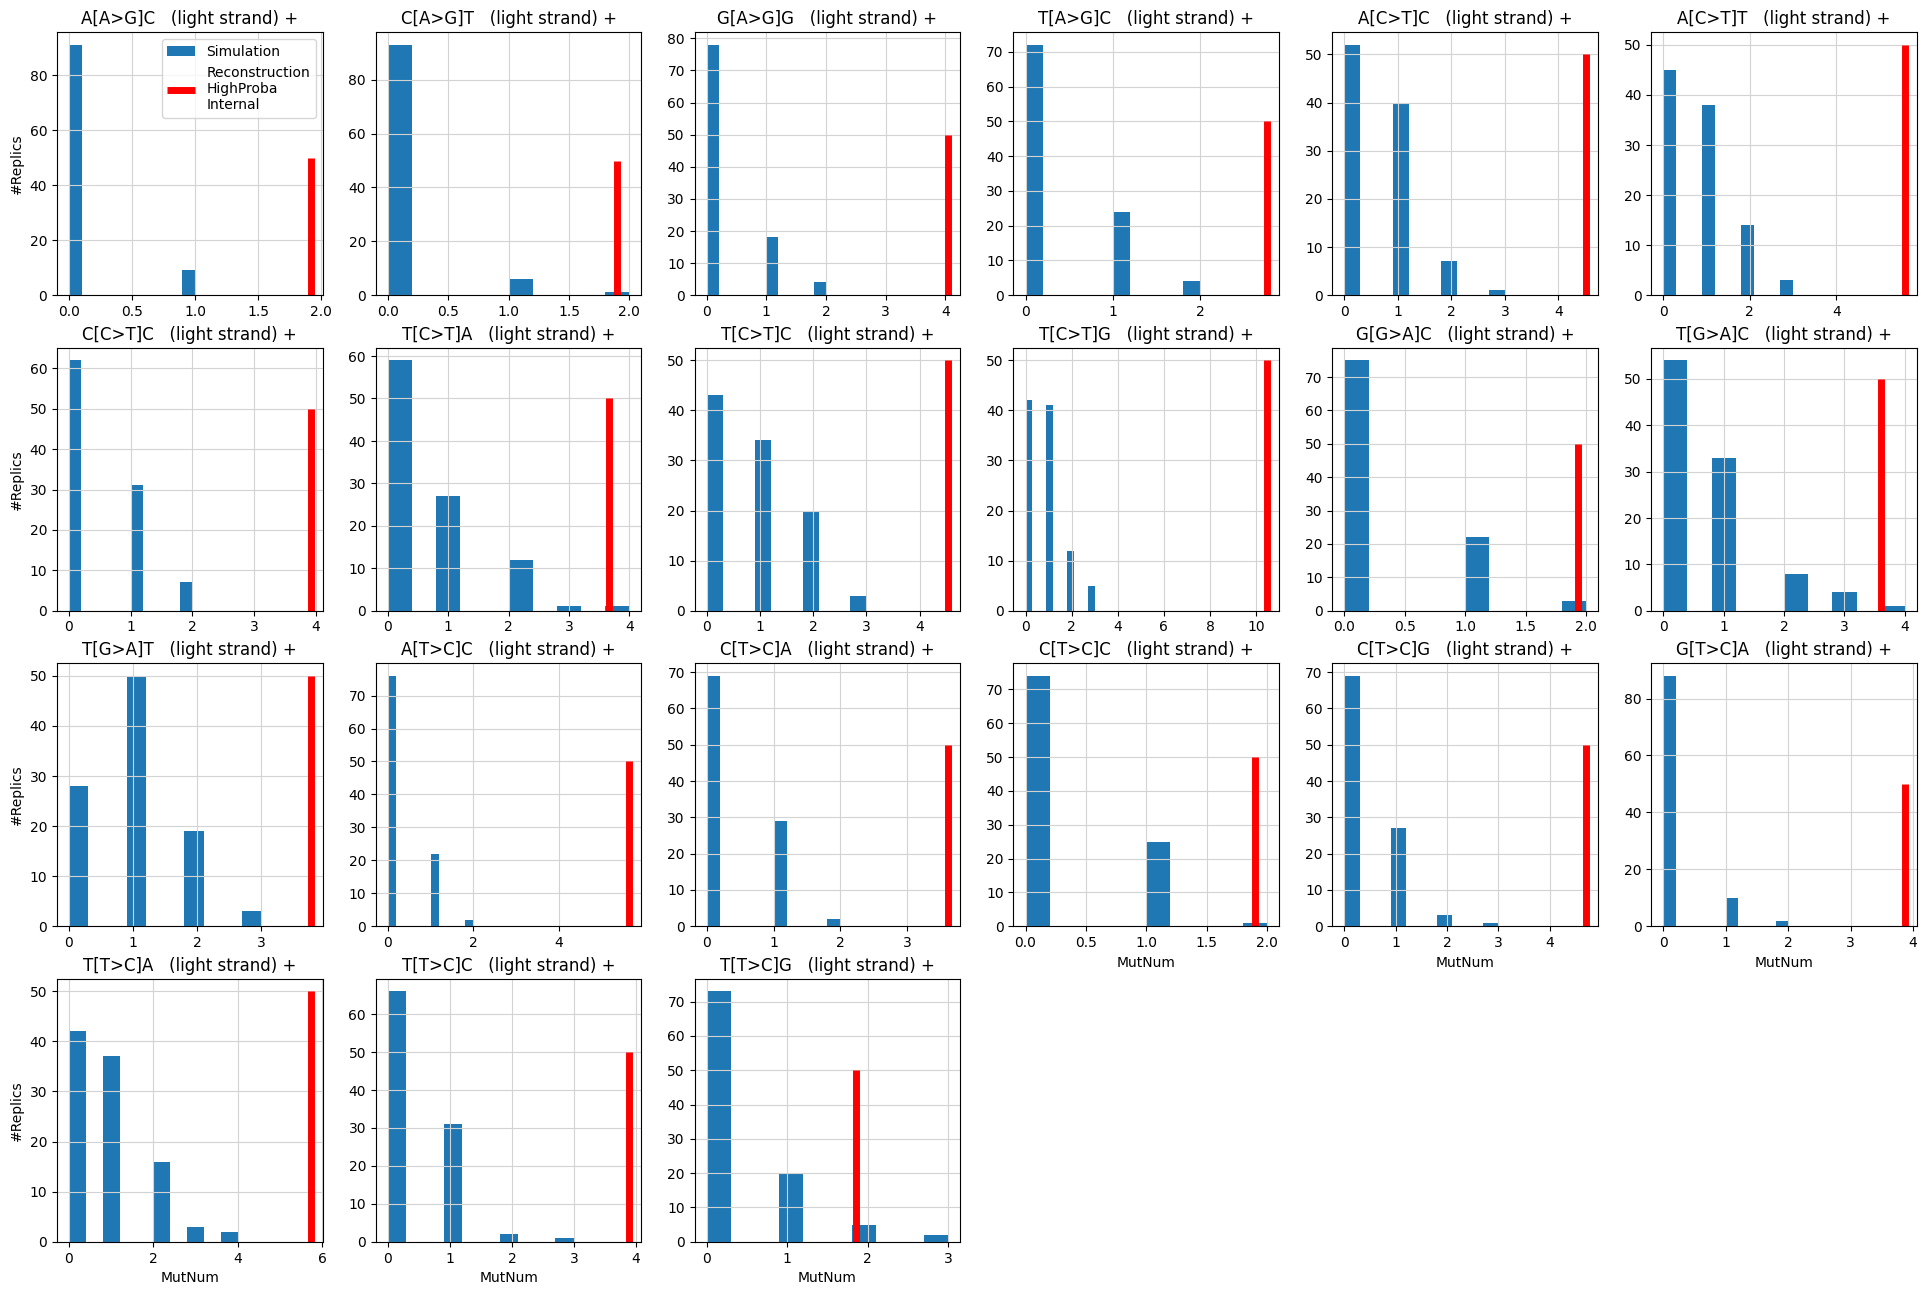

mouse_nd1


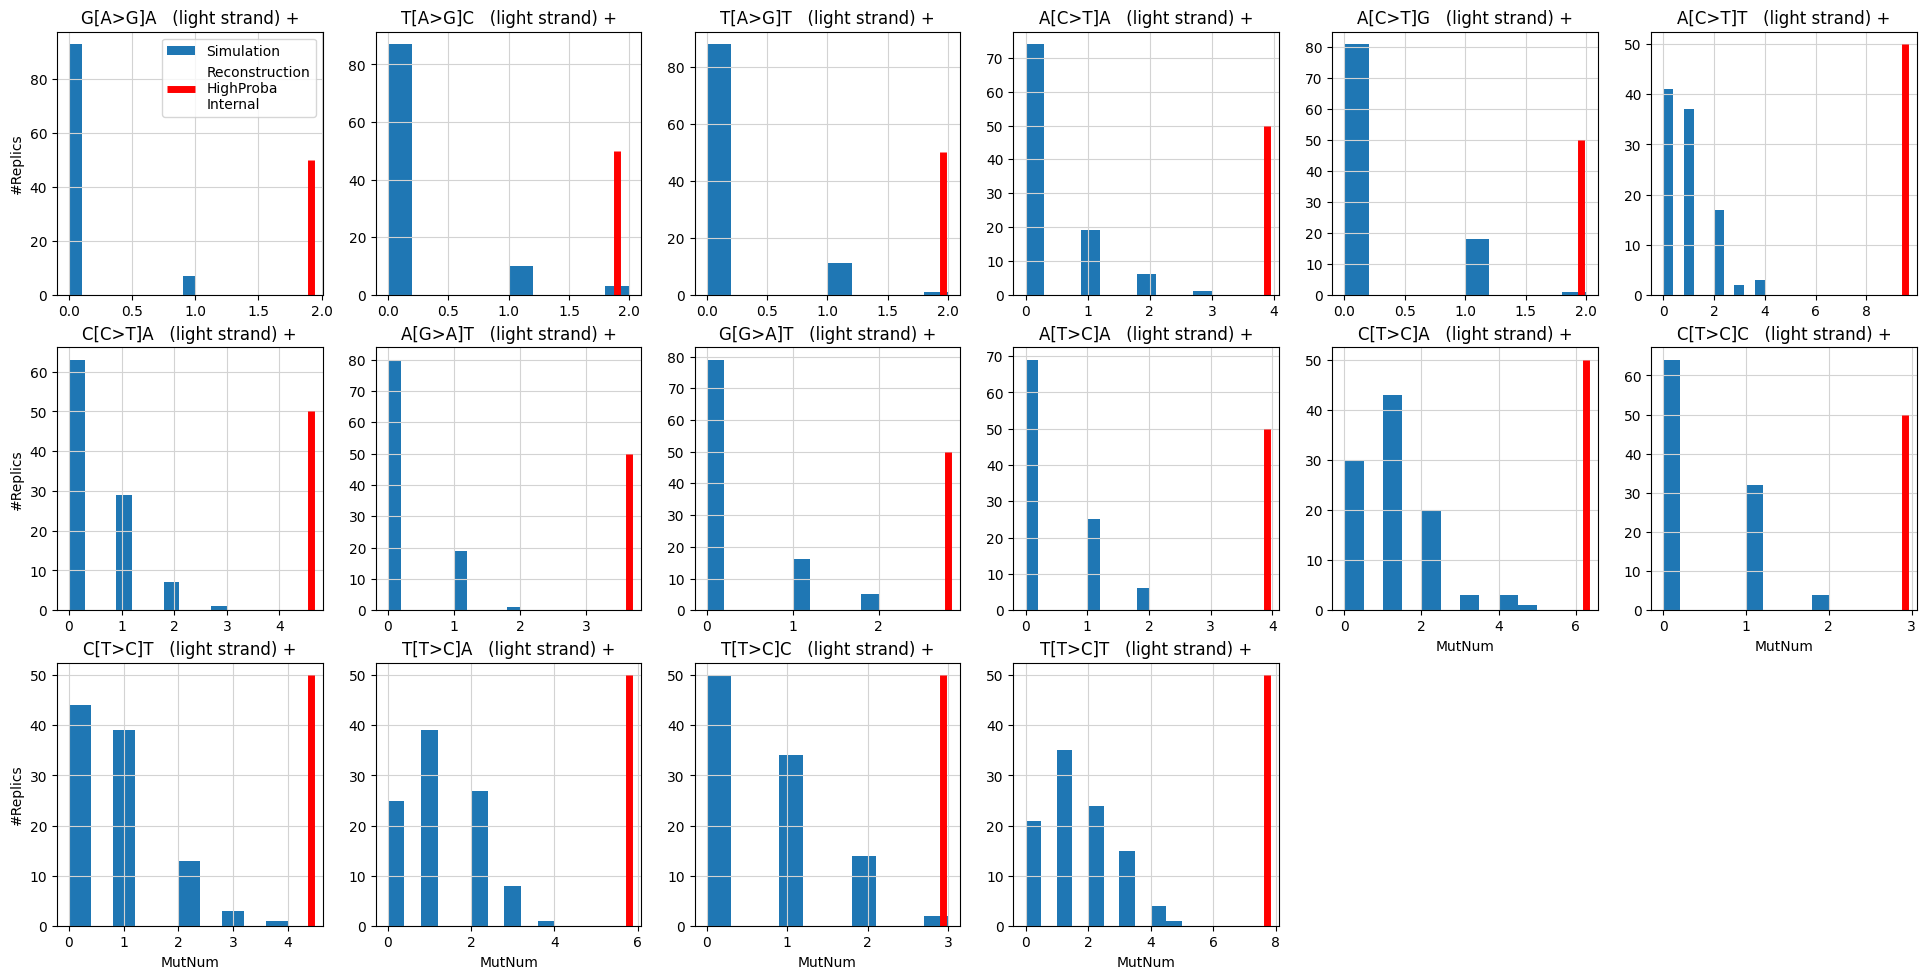

In [96]:
for lbl, data in zip(['human_cytb', 'human_cox1', 'human_nd1', 'mouse_cytb', 'mouse_cox1', 'mouse_nd1'], 
                     [human_cytb, human_cox1, human_nd1, mouse_cytb, mouse_cox1, mouse_nd1]):
    print(lbl)
    high_proba_muts_syn = data["mutations"][
        (data["mutations"].ProbaFull > pcutoff) & 
        (data["mutations"].Label > 0) &
        (data["mutations"].AltNode.str.startswith("Node"))
    ]
    high_proba_obs = high_proba_muts_syn.groupby("Mut").ProbaFull.sum().to_dict()

    nrows, ncols = 7, 6
    plt.figure(figsize=(ncols*4, nrows*4))
    smuts = [x for x in possible_sbs192 if x in data["muts_positive"]]
    effect = "+"
    i=0
    for i, sbs in enumerate(smuts, 1):
        sbs_distro = data["ms_sim192"][data["ms_sim192"].Mut == sbs]
        plt.subplot(nrows, ncols, i)
        plt.grid(color="lightgray")
        sbs_distro.ObsNum.hist(label="Simulation")
        plt.vlines([high_proba_obs[sbs]], 0, 50, "r", linewidth=5, label="Reconstruction\nHighProba\nInternal")
        plt.title(f"{sbs}   (light strand) {effect}")
        if i > len(data["diff_stats_filtered"]) - ncols:
            plt.xlabel("MutNum")
        if i % ncols == 1:
            plt.ylabel("#Replics")
        if i == 1:
            plt.legend()
    k = i + 1
    smuts = [x for x in possible_sbs192 if x in data["muts_negative"]]
    effect = "-"
    for i, sbs in enumerate(smuts, k):
        sbs_distro = data["ms_sim192"][data["ms_sim192"].Mut == sbs]
        plt.subplot(nrows, ncols, i)
        plt.grid(color="lightgray")
        sbs_distro.ObsNum.hist(label="Simulation")
        plt.vlines([high_proba_obs[sbs]], 0, 50, "r", linewidth=5, label="Reconstruction\nHighProba\nInternal")
        plt.title(f"{sbs}   (light strand) {effect}")
        if i > len(data["diff_stats_filtered"]) - ncols:
            plt.xlabel("MutNum")
        if i % ncols == 1:
            plt.ylabel("#Replics")
        if i == 1:
            plt.legend()

    # plt.savefig(f"../figures/selection_search/sbs_significant_{lbl}.pdf", bbox_inches='tight')
    plt.show()


In [44]:
# save files for ET
# human_cytb["both"].drop(["ObsNum_x","ExpNum_x","ObsNum_y","ExpNum_y"], axis=1).to_csv("../data/exposure/stats/human_cytb_simulated_spectra.csv", index=False)
# human_nd1["both"].drop(["ObsNum_x","ExpNum_x","ObsNum_y","ExpNum_y"], axis=1).to_csv("../data/exposure/stats/human_nd1_simulated_spectra.csv", index=False)
# mouse_cytb["both"].drop(["ObsNum_x","ExpNum_x","ObsNum_y","ExpNum_y"], axis=1).to_csv("../data/exposure/stats/mouse_cytb_simulated_spectra.csv", index=False)
# mouse_nd1["both"].drop(["ObsNum_x","ExpNum_x","ObsNum_y","ExpNum_y"], axis=1).to_csv("../data/exposure/stats/mouse_nd1_simulated_spectra.csv", index=False)

# human_cytb["diff_stats"].drop("<lambda_0>", axis=1).to_csv("../data/exposure/stats/human_cytb_stats.csv")
# human_nd1["diff_stats"].drop("<lambda_0>", axis=1).to_csv("../data/exposure/stats/human_nd1_stats.csv")
# mouse_cytb["diff_stats"].drop("<lambda_0>", axis=1).to_csv("../data/exposure/stats/mouse_cytb_stats.csv")
# mouse_nd1["diff_stats"].drop("<lambda_0>", axis=1).to_csv("../data/exposure/stats/mouse_nd1_stats.csv")

In [6]:
for lbl, data in zip(['human_cytb', 'human_cox1', 'human_nd1', 'mouse_cytb', 'mouse_cox1', 'mouse_nd1'], 
                     [human_cytb, human_cox1, human_nd1, mouse_cytb, mouse_cox1, mouse_nd1]):
    print(lbl)
    print("muts_positive:", list(data["muts_positive"]))
    print("muts_negative:", list(data["muts_negative"]))
    print()

human_cytb
muts_positive: ['A[A>G]C', 'A[C>T]A', 'C[A>G]A', 'C[A>G]C', 'C[A>T]G', 'C[C>T]A', 'C[C>T]G', 'C[T>C]T', 'C[T>G]A', 'G[A>G]C', 'G[A>G]G', 'G[A>G]T', 'G[C>A]C', 'G[C>T]C', 'G[C>T]G', 'G[G>A]C', 'T[T>C]C']
muts_negative: ['A[C>T]T', 'A[G>A]C', 'A[T>C]T', 'C[C>T]T', 'C[G>A]G', 'C[G>A]T', 'C[T>C]A', 'T[A>G]A', 'T[C>T]A', 'T[C>T]C', 'T[C>T]T', 'T[G>A]A', 'T[G>A]C', 'T[T>C]A', 'T[T>C]G', 'T[T>C]T']

human_cox1
muts_positive: ['A[A>G]C', 'A[C>T]A', 'A[G>A]G', 'A[T>C]T', 'C[A>G]C', 'C[A>G]G', 'C[C>A]G', 'C[C>G]T', 'C[G>A]A', 'C[T>C]A', 'C[T>C]C', 'C[T>C]T', 'C[T>G]C', 'C[T>G]G', 'G[A>G]A', 'G[A>G]C', 'G[A>G]G', 'G[A>G]T', 'G[C>T]T', 'G[T>C]A', 'G[T>C]C', 'T[A>G]C', 'T[A>G]G', 'T[C>A]G', 'T[C>T]A', 'T[C>T]G']
muts_negative: ['A[G>A]C', 'A[T>C]G', 'C[C>T]T', 'C[G>A]T', 'C[T>C]G', 'T[C>T]T', 'T[G>A]C', 'T[G>A]G', 'T[T>C]G', 'T[T>C]T']

human_nd1
muts_positive: ['A[A>G]A', 'A[A>G]C', 'A[C>T]A', 'A[C>T]C', 'A[C>T]G', 'A[G>A]C', 'A[G>A]T', 'A[T>C]G', 'C[A>G]A', 'C[A>G]G', 'C[A>G]T', 'C[C>T

In [105]:
# # human_cytb
# muts_positive = ['A[A>G]C', 'A[C>T]A', 'C[A>G]A', 'C[A>G]C', 'C[A>T]G', 'C[C>T]A', 'C[C>T]G', 'C[T>C]T', 'C[T>G]A', 'G[A>G]C', 'G[A>G]G', 'G[A>G]T', 'G[C>A]C', 'G[C>T]C', 'G[C>T]G', 'G[G>A]C', 'T[T>C]C']
# muts_negative = ['A[C>T]T', 'A[G>A]C', 'A[T>C]T', 'C[C>T]T', 'C[G>A]G', 'C[G>A]T', 'C[T>C]A', 'T[A>G]A', 'T[C>T]A', 'T[C>T]C', 'T[C>T]T', 'T[G>A]A', 'T[G>A]C', 'T[T>C]A', 'T[T>C]G', 'T[T>C]T']

# # human_cox1
# muts_positive = ['A[A>G]C', 'A[C>T]A', 'A[G>A]G', 'A[T>C]T', 'C[A>G]C', 'C[A>G]G', 'C[C>A]G', 'C[C>G]T', 'C[G>A]A', 'C[T>C]A', 'C[T>C]C', 'C[T>C]T', 'C[T>G]C', 'C[T>G]G', 'G[A>G]A', 'G[A>G]C', 'G[A>G]G', 'G[A>G]T', 'G[C>T]T', 'G[T>C]A', 'G[T>C]C', 'T[A>G]C', 'T[A>G]G', 'T[C>A]G', 'T[C>T]A', 'T[C>T]G']
# muts_negative = ['A[G>A]C', 'A[T>C]G', 'C[C>T]T', 'C[G>A]T', 'C[T>C]G', 'T[C>T]T', 'T[G>A]C', 'T[G>A]G', 'T[T>C]G', 'T[T>C]T']

# # human_nd1
# muts_positive = ['A[A>G]A', 'A[A>G]C', 'A[C>T]A', 'A[C>T]C', 'A[C>T]G', 'A[G>A]C', 'A[G>A]T', 'A[T>C]G', 'C[A>G]A', 'C[A>G]G', 'C[A>G]T', 'C[C>T]A', 'C[C>T]C', 'C[C>T]G', 'C[C>T]T', 'C[G>A]A', 'C[T>A]C', 'G[A>G]A', 'G[A>G]C', 'G[A>G]G', 'G[A>G]T', 'G[C>T]C', 'G[G>A]C', 'G[G>A]G', 'G[G>A]T', 'T[A>G]G', 'T[C>A]T', 'T[C>T]A', 'T[G>A]A', 'T[T>A]T', 'T[T>C]C']
# muts_negative = ['A[C>T]T', 'A[T>C]T', 'C[T>C]A', 'C[T>C]C', 'T[G>A]G', 'T[T>C]A']

# for a in muts_positive:
#     b = rev_comp(a) 
#     if b in muts_negative:
#         print(a, b)

A[G>A]T A[C>T]T
C[C>T]A T[G>A]G
G[A>G]G C[T>C]C
T[A>G]G C[T>C]A


### impose mutations effect on genome

In [57]:
for gene, data in zip(['human_cytb', 'human_cox1', 'human_nd1', 'mouse_cytb', 'mouse_cox1', 'mouse_nd1'], 
                      [human_cytb, human_cox1, human_nd1, mouse_cytb, mouse_cox1, mouse_nd1]):
    high_proba_muts_syn = data["mutations"][
        (data["mutations"].ProbaFull > pcutoff) & 
        (data["mutations"].Label > 0) &
        (data["mutations"].AltNode.str.startswith("Node")) & 
        (data["mutations"].Mut.isin(list(data["muts_positive"]) + list(data["muts_negative"])))
    ].drop(["ProbaRef", "ProbaMut", "Gene", "AltAa"], axis=1)
    high_proba_muts_syn["Effect"] = high_proba_muts_syn.Mut.map(
        dict(**{x:"+" for x in data["muts_positive"]}, **{x:"-" for x in data["muts_negative"]})
    )
    high_proba_muts_syn.to_csv(f"../data/selection_search/position_analysis/{gene}_obs_muts_with_effect.csv", index=False)


In [111]:
# fout = open("../data/exposure/consensus_labels_fr_syn2.txt", "w")
# for lbl, data in zip(['human_cytb', 'human_cox1', 'human_nd1', 'mouse_cytb', 'mouse_cox1', 'mouse_nd1'], [human_cytb, human_cox1, human_nd1, mouse_cytb, mouse_cox1, mouse_nd1]):
#     fout.write(">"+lbl+"\n")
#     fout.write(data['consensus']+"\n")
#     muts_plus = data["mutations"][data["mutations"].Mut.isin(data["muts_positive"])]
#     muts_minus = data["mutations"][data["mutations"].Mut.isin(data["muts_negative"])]

#     muts_plus_est = muts_plus[muts_plus.Label >= 1].groupby(["Mut", "PosInGene"]).ProbaFull.sum()
#     muts_minus_est = muts_minus[muts_minus.Label >= 1].groupby(["Mut", "PosInGene"]).ProbaFull.sum()

#     pos_plus  = set(muts_plus_est[muts_plus_est > 0.5].reset_index().PosInGene.values)
#     pos_minus = set(muts_minus_est[muts_minus_est > 0.5].reset_index().PosInGene.values)

#     for pos in range(1, len(data['consensus'])+1):
#         if pos in pos_plus:
#             fout.write("+")
#         elif pos in pos_minus:
#             fout.write("-")
#         else:
#             fout.write(" ")
#     fout.write("\n\n")

# fout.close()

## Sample syn mutations

### Random mutation in random position

In [58]:
coda = CodonAnnotation(2)

In [87]:
def sample_mutations(muts, n):
    positions = np.random.choice(muts.Pos.unique(), n, replace=True)
    muts_sample1 = muts[muts.Pos.isin(positions)].groupby("Pos").sample()
    c = Counter(positions)
    samples_up1 = []
    for pos, k in c.most_common(len(positions)):
        if k > 1:
            d = muts[muts.Pos == pos]
            samples_up1.append(d.sample(k - 1, replace=True))
        else:
            break
    if len(samples_up1):
        muts_sample2 = pd.concat(samples_up1)
        total_samples = pd.concat([muts_sample1, muts_sample2])
    else:
        total_samples = muts_sample1
    assert len(total_samples) == n
    return total_samples

In [99]:
nsamples = 100

for gene, data in zip(['human_cytb', 'human_cox1', 'human_nd1', 'mouse_cytb', 'mouse_cox1', 'mouse_nd1'], 
                     [human_cytb, human_cox1, human_nd1, mouse_cytb, mouse_cox1, mouse_nd1]):
    emuts = coda.collect_exp_muts(data["consensus"])
    emuts = emuts[emuts.Pos.isin(data["var_pos"])]
    emuts = emuts.merge(data['rate'][["Site", "Cat"]], left_on="Pos", right_on="Site")\
        .drop(["Site", "Label"], axis=1)
    
    n = round(data["mutations"][
        (data["mutations"].Label > 0) & 
        (data["mutations"].AltNode.str.startswith("Node")) & 
        (data["mutations"].ProbaFull > 0.3)
    ].ProbaFull.sum())
    print(gene, n)
    
    samples = []
    for i in range(nsamples):
        s = sample_mutations(emuts, n)
        s["Replic"] = i + 1
        samples.append(s)
    samples_df = pd.concat(samples)
    data["samples"] = samples_df
    samples_df.to_csv(f"../data/selection_search/sampling_uniform/{gene}_mut_samples_uniform.csv", index=False)

human_cytb 725
human_cox1 879
human_nd1 558
mouse_cytb 238
mouse_cox1 129
mouse_nd1 97


### Spectra-specific sampling

In [60]:
from scipy.stats import multinomial

coda = CodonAnnotation(2)

In [61]:
md = multinomial(100, [0.1, 0.4, 0.3, 0.195, 0.005])
md.rvs(3)

array([[13, 42, 37,  8,  0],
       [ 8, 44, 30, 18,  0],
       [14, 48, 19, 19,  0]])

In [86]:
def sample_sbs_counts(muts, sbs_counts: dict):
    sbs_samples = []
    for sbs, cnt in sbs_counts.items():
        if cnt < 1:
            continue
        cur_muts = muts[muts.Mut.str.slice(2,5) == sbs]
        if len(cur_muts):
            s = cur_muts.sample(cnt, replace=True)
            sbs_samples.append(s)

    return pd.concat(sbs_samples)


nsamples = 100

for gene, data in zip(['human_cytb', 'human_cox1', 'human_nd1', 'mouse_cytb', 'mouse_cox1', 'mouse_nd1'], 
                      [human_cytb, human_cox1, human_nd1, mouse_cytb, mouse_cox1, mouse_nd1]):
    #get possible syn mutations
    emuts = coda.collect_exp_muts(data["consensus"])
    emuts = emuts[emuts.Pos.isin(data["var_pos"])]
    emuts = emuts.merge(data['rate'][["Site", "Cat"]], left_on="Pos", right_on="Site")\
        .drop(["Site", "Label"], axis=1)

    #access obs muts
    cur_obs_muts = data["mutations"][
        (data["mutations"].Label > 0) & 
        (data["mutations"].AltNode.str.startswith("Node")) & 
        (data["mutations"].ProbaFull > 0.3)
    ]
    n = round(cur_obs_muts.ProbaFull.sum())  #number of mutations to sample
    print(gene, n)

    # calculate observed freqs to sample mutations with such freqs from full list of syn mutations
    cur_obs_muts["MutBase"] = cur_obs_muts.Mut.str.slice(2, 5)
    obs12 = cur_obs_muts.groupby("MutBase").ProbaFull.sum()
    obs12 = (obs12 / obs12.sum()).to_dict()
    obs12 = {sbs: obs12.get(sbs, 0.001) for sbs in possible_sbs12}
    obs12 = {sbs: p / sum(obs12.values()) for sbs, p in obs12.items()}
    assert len(obs12) == 12
    sbs_types, probas = obs12.keys(), list(obs12.values())

    #sample
    md = multinomial(n, probas)
    samples = []
    for i, sbs_counts in enumerate(md.rvs(nsamples)):
        sbs_counts = dict(zip(sbs_types, sbs_counts))
        s = sample_sbs_counts(emuts, sbs_counts)
        s["Replic"] = i + 1
        samples.append(s)
    samples_df = pd.concat(samples)
    data["samples"] = samples_df
    samples_df.to_csv(f"../data/selection_search/spectra_based_sampling/{gene}_mut_samples.csv", index=False)


human_cytb 725
human_cox1 879
human_nd1 558
mouse_cytb 238
mouse_cox1 129
mouse_nd1 97
